# Part 1. EDA

## 1.1 Load The Data

In [ ]:

"""
Ride Hailing Data Analysis and Cancellation Prediction
"""

# --- 0. Setup and Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             make_scorer, classification_report,
                             confusion_matrix, accuracy_score)
from imblearn.over_sampling import SMOTE 
import warnings

warnings.filterwarnings('ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=UserWarning) 


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("Libraries imported and settings configured.")

# --- 1. Load the Data ---

try:

    df = pd.read_csv('data/HR_Assessment_Data_Data Scientist_Raw Data.csv')
    print("Dataset loaded successfully from sample data.")

except FileNotFoundError:
    print("Error: The specified CSV file was not found.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit()


Libraries imported and settings configured.
Dataset loaded successfully from sample data.


## 1.2 Initial Inspection & Key Characteristics

In [71]:

# --- 2. Initial Inspection & Key Characteristics ---

print("\n--- Dataset Overview ---")
print(f"Shape (Rows, Columns): {df.shape}")
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Data Types and Non-Null Counts ---")
# Use verbose=True for more detail if columns are truncated
df.info(verbose=True)
print("\n--- Summary Statistics for Numerical Features ---")
print(df.describe(include=[np.number]))
print("\n--- Summary Statistics for Categorical Features ---")
print(df.describe(include=['object'])) # 'object' covers strings



--- Dataset Overview ---
Shape (Rows, Columns): (20, 11)

--- First 5 Rows ---
  ride_id user_id driver_id           start_time             end_time  \
0   R0001      U1        D1  2025-01-01 08:00:00  2025-01-01 08:30:00   
1   R0002      U2        D2  2025-01-01 09:00:00  2025-01-01 09:30:00   
2   R0003      U3        D3  2025-01-01 10:00:00  2025-01-01 10:30:00   
3   R0004      U4        D4  2025-01-01 11:00:00  2025-01-01 11:30:00   
4   R0005      U5        D1  2025-01-01 12:00:00  2025-01-01 12:30:00   

  pickup_location dropoff_location  fare  distance_km  rating  cancelled  
0            LocA             LocB   5.0          1.0       5          0  
1            LocB             LocC   5.5          1.2       4          0  
2            LocC             LocD   6.0          1.4       3          1  
3            LocD             LocA   6.5          1.6       2          0  
4            LocA             LocB   7.0          1.8       1          0  

--- Data Types and Non-Null Co

## 1.3 Data Cleaning & Issue Identification 

In [72]:

# --- 3. Data Cleaning & Issue Identification ---

print("\n--- Checking for Missing Values ---")
missing_values = df.isnull().sum()
missing_cols = missing_values[missing_values > 0]
if not missing_cols.empty:
    print("Missing values found:")
    print(missing_cols)
    print(f"Total missing values: {missing_values.sum()}")

else:
    print("No missing values found.")

print("\n--- Checking for Duplicate Rows ---")
duplicate_rows = df.duplicated().sum()
if duplicate_rows == 0:
    print("No duplicate rows found.")
else:
    print(f"Found {duplicate_rows} duplicate rows.")
    # Action: Typically drop duplicates, keeping the first instance.
    df = df.drop_duplicates(keep='first', inplace=False)
    print("Duplicate rows dropped (if any).")

print("\n--- Checking Data Type Correctness & Value Ranges ---")
# Convert timestamp columns to datetime objects
time_conversion_success = False
try:
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    print("Converted 'start_time' and 'end_time' to datetime objects.")
    time_conversion_success = True
except Exception as e:
    print(f"Error converting time columns: {e}")

# Verify rating range (assuming 1-5)
if 'rating' in df.columns and pd.api.types.is_numeric_dtype(df['rating']):
    min_rating, max_rating = df['rating'].min(), df['rating'].max()
    print(f"Rating range: {min_rating} - {max_rating}")
    if not (df['rating'].between(1, 5, inclusive='both').all()):
        print("Warning: Ratings found outside the expected 1-5 range.")
else:
    print("Rating column not found or not numeric.")

# Verify cancelled values (assuming 0 or 1)
if 'cancelled' in df.columns and pd.api.types.is_numeric_dtype(df['cancelled']):
    unique_cancelled = df['cancelled'].unique()
    print(f"Unique values in 'cancelled': {unique_cancelled}")
    if not all(val in [0, 1] for val in unique_cancelled):
        print("Warning: Unexpected values found in 'cancelled' column.")
else:
    print("Cancelled column not found or not numeric.")

# Verify non-negative fare and distance
if 'fare' in df.columns and pd.api.types.is_numeric_dtype(df['fare']) and (df['fare'] < 0).any():
    print("Warning: Negative values found in 'fare'.")
if 'distance_km' in df.columns and pd.api.types.is_numeric_dtype(df['distance_km']) and (df['distance_km'] < 0).any():
    print("Warning: Negative values found in 'distance_km'.")

# Sort dataframe by start time for time-based features/analysis
if time_conversion_success:
    df = df.sort_values(by='start_time').reset_index(drop=True)
    print("DataFrame sorted by 'start_time'.")
else:
    print("DataFrame not sorted by time due to conversion issues.")



--- Checking for Missing Values ---
No missing values found.

--- Checking for Duplicate Rows ---
No duplicate rows found.

--- Checking Data Type Correctness & Value Ranges ---
Converted 'start_time' and 'end_time' to datetime objects.
Rating range: 1 - 5
Unique values in 'cancelled': [0 1]
DataFrame sorted by 'start_time'.


## 1.4 Feature Engineering

In [ ]:

# --- 4. Feature Engineering ---

print("\n--- Feature Engineering: Basic Time & Speed Features ---")
if time_conversion_success:

    df['trip_duration_minutes'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
    print("Created 'trip_duration_minutes' feature.")

    if (df['trip_duration_minutes'] <= 0).any():
        print("Warning: Found trips with non-positive duration.")

    # Extract time features
    df['start_hour'] = df['start_time'].dt.hour
    df['start_dayofweek'] = df['start_time'].dt.dayofweek # Monday=0, Sunday=6
    df['start_dayname'] = df['start_time'].dt.day_name()
    df['start_date'] = df['start_time'].dt.date
    print("Extracted hour, day of week, day name, and date features from 'start_time'.")


    epsilon = 1e-6
    df['avg_speed_kmh'] = df['distance_km'] / ((df['trip_duration_minutes'] + epsilon) / 60)
    # Explicitly set speed to 0 if distance is 0, handle non-positive duration if applicable
    df.loc[df['distance_km'] == 0, 'avg_speed_kmh'] = 0
    df.loc[df['trip_duration_minutes'] <= 0, 'avg_speed_kmh'] = np.nan # Or 0, depends on how you want to treat it
    print("Calculated 'avg_speed_kmh'.")
else:
    print("Skipping time-based feature engineering due to timestamp conversion issues.")


print("\n--- Feature Engineering: Rolling Window & RFM-like Features (User/Driver History) ---")


metrics_to_roll = ['fare', 'distance_km', 'trip_duration_minutes', 'cancelled', 'rating']

window_size = 3

# --- User Rolling Features ---
print("Calculating user rolling features...")
df = df.sort_values(by=['user_id', 'start_time']) 

for metric in metrics_to_roll:
    if metric in df.columns:
        # Previous value
        df[f'user_prev_{metric}'] = df.groupby('user_id')[metric].shift(1)
        # Rolling mean over N previous rides
        df[f'user_rolling_mean_{window_size}_{metric}'] = df.groupby('user_id')[metric].shift(1).rolling(window=window_size, min_periods=1).mean()
        # Rolling sum (makes sense for fare, distance, duration)
        if metric not in ['cancelled', 'rating']: # Summing rates/ratings isn't usually meaningful
             df[f'user_rolling_sum_{window_size}_{metric}'] = df.groupby('user_id')[metric].shift(1).rolling(window=window_size, min_periods=1).sum()

# Example: User's rolling cancellation rate based on last N rides
df[f'user_rolling_cancel_rate_{window_size}'] = df.groupby('user_id')['cancelled'].shift(1).rolling(window=window_size, min_periods=1).mean()

# --- Driver Rolling Features ---
print("Calculating driver rolling features...")
df = df.sort_values(by=['driver_id', 'start_time']) 

for metric in metrics_to_roll:
     if metric in df.columns:
        df[f'driver_prev_{metric}'] = df.groupby('driver_id')[metric].shift(1)
        df[f'driver_rolling_mean_{window_size}_{metric}'] = df.groupby('driver_id')[metric].shift(1).rolling(window=window_size, min_periods=1).mean()
        if metric not in ['cancelled', 'rating']:
            df[f'driver_rolling_sum_{window_size}_{metric}'] = df.groupby('driver_id')[metric].shift(1).rolling(window=window_size, min_periods=1).sum()

df[f'driver_rolling_cancel_rate_{window_size}'] = df.groupby('driver_id')['cancelled'].shift(1).rolling(window=window_size, min_periods=1).mean()

# --- RFM-like Features (User-based Cumulative History) ---
print("Calculating user RFM-like features (cumulative)...")
df = df.sort_values(by=['user_id', 'start_time']) 

# Frequency: Number of rides taken before this one
df['user_ride_count_before'] = df.groupby('user_id').cumcount()

# Recency: Time since the user's last ride
if time_conversion_success:
    df['user_prev_start_time'] = df.groupby('user_id')['start_time'].shift(1)
    # Calculate difference in days (can be fractional)
    df['user_days_since_last_ride'] = (df['start_time'] - df['user_prev_start_time']).dt.total_seconds() / (60*60*24)
    # Drop the temporary column
    df = df.drop(columns=['user_prev_start_time'], errors='ignore')
else:
    df['user_days_since_last_ride'] = np.nan 

# Monetary (Cumulative & Average Fare before this ride)
df['user_total_fare_before'] = df.groupby('user_id')['fare'].shift(1).expanding().sum()
df['user_avg_fare_before'] = df.groupby('user_id')['fare'].shift(1).expanding().mean()

# Behavioral (Cumulative Cancellation Rate before this ride)
df['user_total_cancelled_before'] = df.groupby('user_id')['cancelled'].shift(1).expanding().sum()
# Avoid division by zero for the first ride (ride_count_before is 0)
df['user_cancel_rate_before'] = (df['user_total_cancelled_before'] / df['user_ride_count_before'])
df = df.drop(columns=['user_total_cancelled_before'], errors='ignore') 

# --- Handle NaNs from Feature Engineering ---

print("Handling NaNs created during feature engineering...")

fill_zero_cols = [col for col in df.columns if 'prev_' in col or 'rolling_' in col or '_before' in col]

if 'user_days_since_last_ride' in fill_zero_cols:
    fill_zero_cols.remove('user_days_since_last_ride')

for col in fill_zero_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)


# Handle recency NaN (first ride) - fill with a special value like -1 or a large number
if 'user_days_since_last_ride' in df.columns:
    df['user_days_since_last_ride'] = df['user_days_since_last_ride'].fillna(-1)


# Handle potential 0/0 division in user_cancel_rate_before (first ride) -> results in NaN, fill with 0
if 'user_cancel_rate_before' in df.columns:
    df['user_cancel_rate_before'] = df['user_cancel_rate_before'].fillna(0)


# Handle potential NaN in avg_speed_kmh if duration was non-positive and wasn't handled earlier
if 'avg_speed_kmh' in df.columns:
    # Fill with median speed, as 0 might be misleading if distance > 0
    median_speed = df['avg_speed_kmh'].median()
    df['avg_speed_kmh'] = df['avg_speed_kmh'].fillna(median_speed if pd.notna(median_speed) else 0)


df = df.sort_values(by='start_time').reset_index(drop=True)

print("\n--- Sample of DataFrame with New Features ---")

pd.set_option('display.max_columns', 50)
print(df.head())
pd.reset_option('display.max_columns')
print(f"\nTotal features now: {df.shape[1]}")




--- Feature Engineering: Basic Time & Speed Features ---
Created 'trip_duration_minutes' feature.
Extracted hour, day of week, day name, and date features from 'start_time'.
Calculated 'avg_speed_kmh'.

--- Feature Engineering: Rolling Window & RFM-like Features (User/Driver History) ---
Calculating user rolling features...
Calculating driver rolling features...
Calculating user RFM-like features (cumulative)...
Handling NaNs created during feature engineering...

--- Sample of DataFrame with New Features ---
  ride_id user_id driver_id          start_time            end_time  \
0   R0001      U1        D1 2025-01-01 08:00:00 2025-01-01 08:30:00   
1   R0002      U2        D2 2025-01-01 09:00:00 2025-01-01 09:30:00   
2   R0003      U3        D3 2025-01-01 10:00:00 2025-01-01 10:30:00   
3   R0004      U4        D4 2025-01-01 11:00:00 2025-01-01 11:30:00   
4   R0005      U5        D1 2025-01-01 12:00:00 2025-01-01 12:30:00   

  pickup_location dropoff_location  fare  distance_km  ra

## 1.5 Univariate Analysis


--- Univariate Analysis (Visualizations) ---
Visualizing distributions of key numerical features...


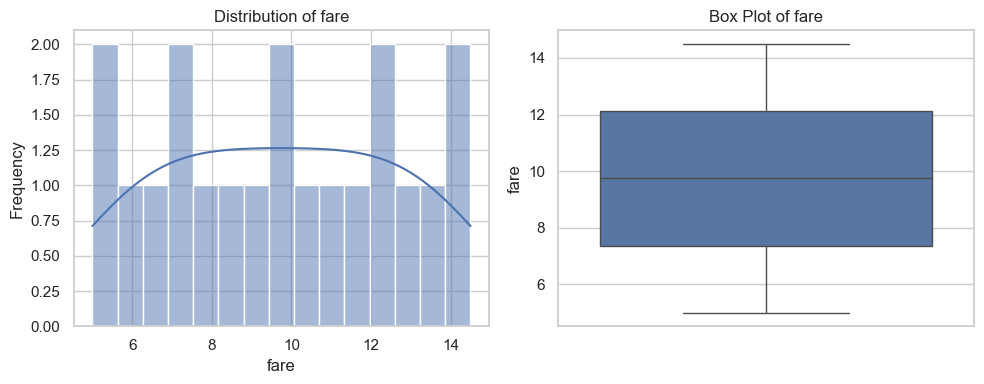

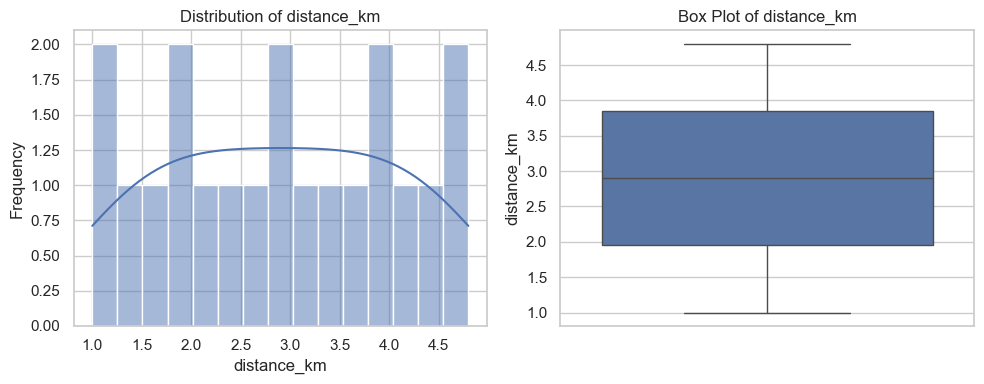

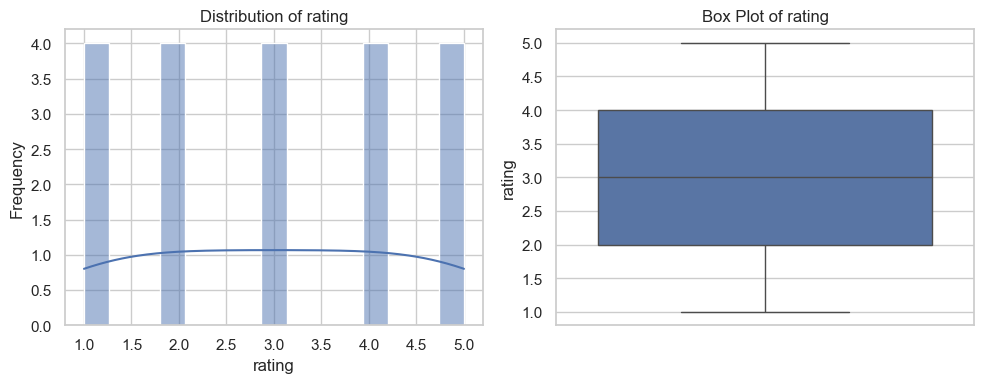

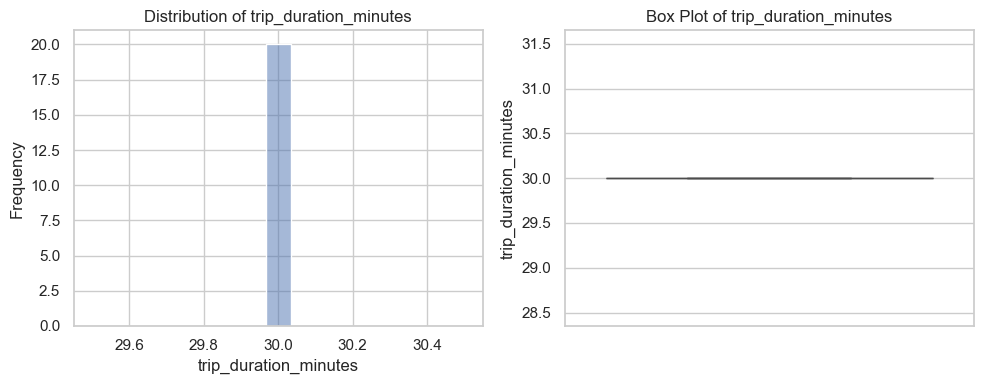

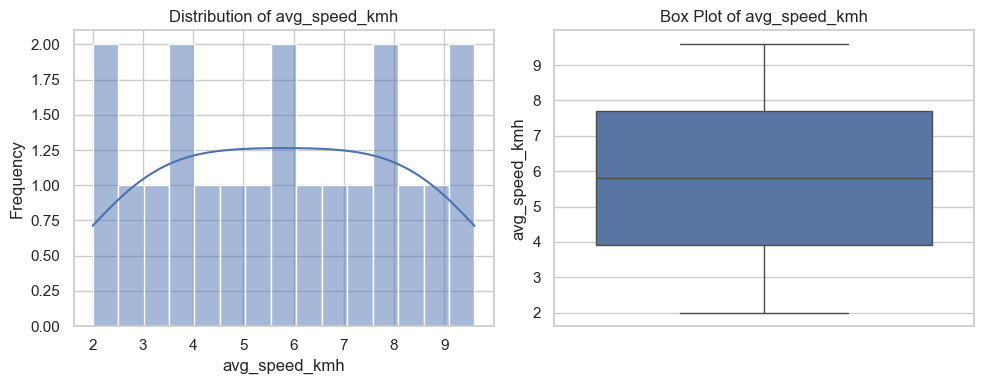


Visualizing frequencies of key categorical features...


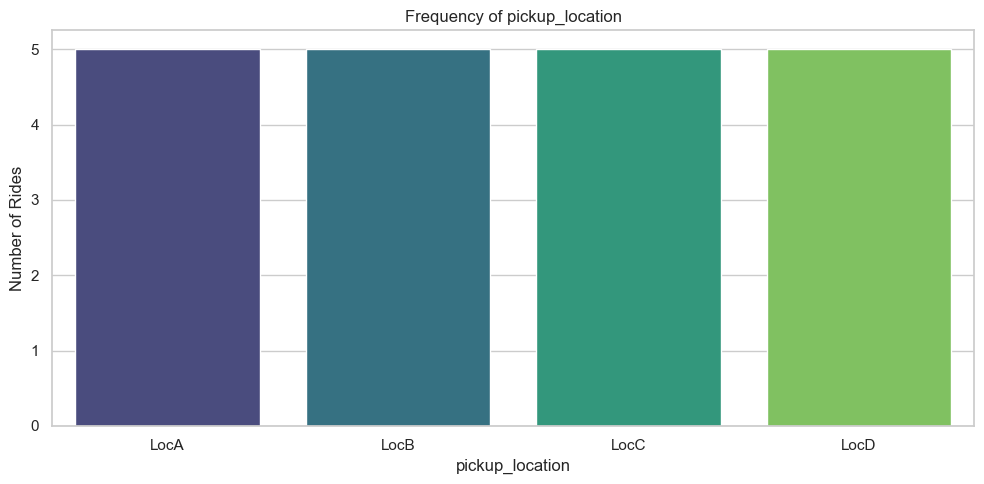

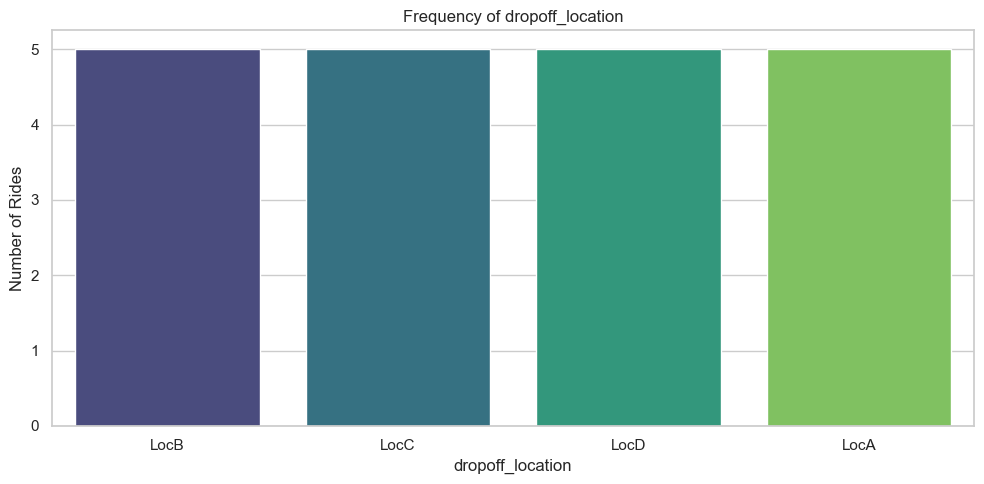

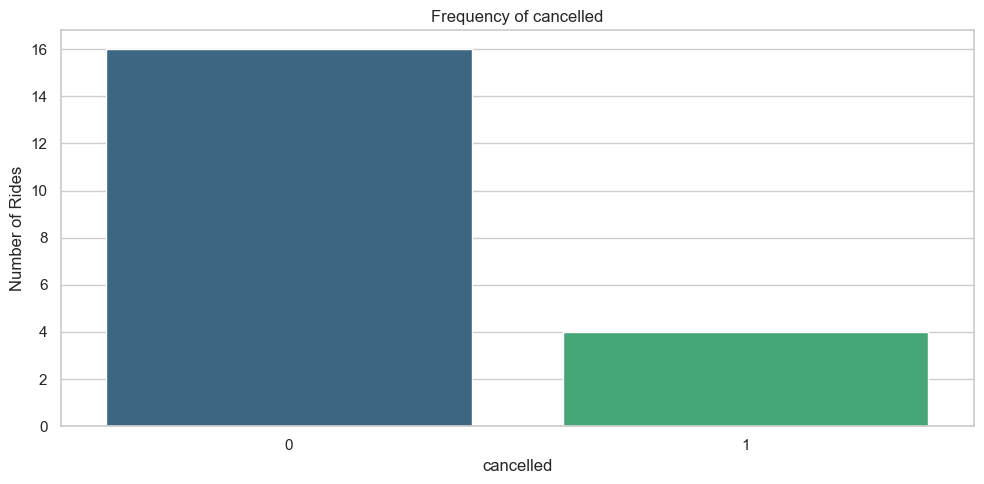

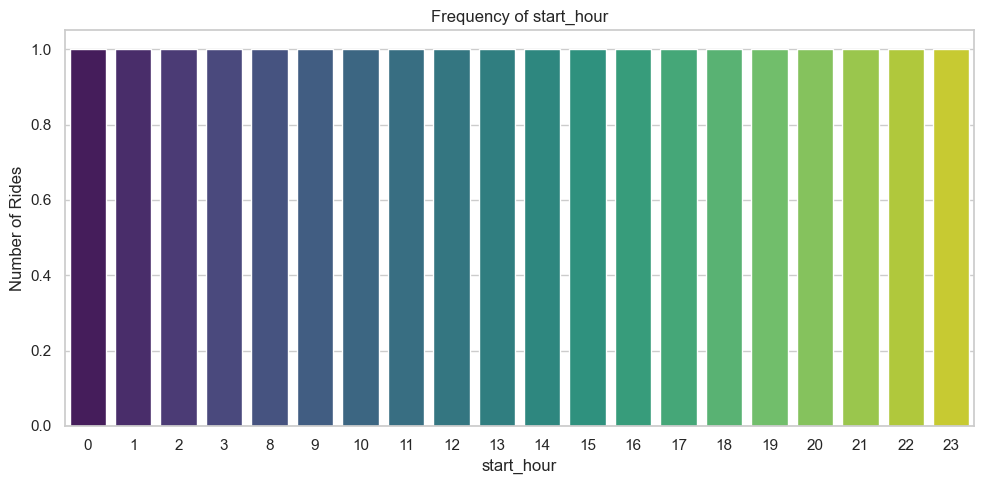

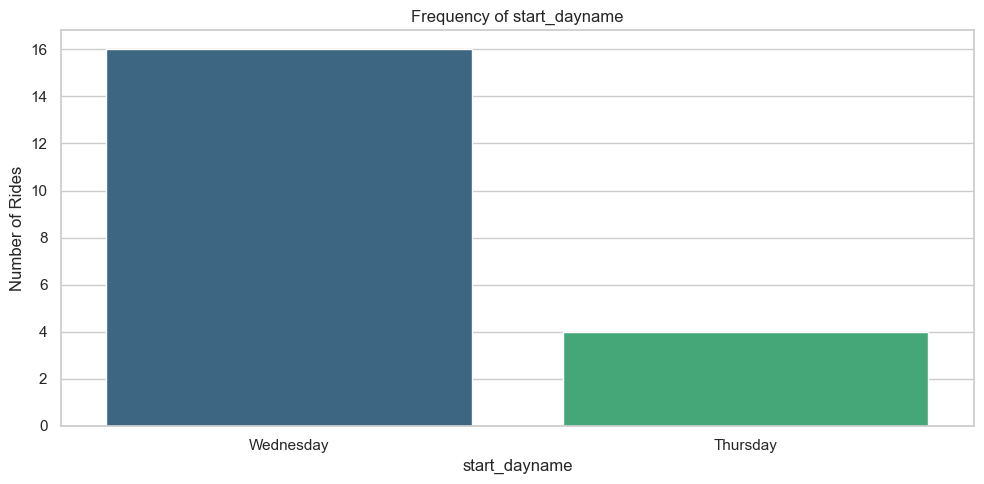

In [ ]:

# --- 5. Exploratory Data Analysis (Continued - Visualization) ---

print("\n--- Univariate Analysis (Visualizations) ---")

# Distribution of Key Numerical Features (Including Basic Engineered)
numerical_features_to_plot = ['fare', 'distance_km', 'rating', 'trip_duration_minutes', 'avg_speed_kmh']
print("Visualizing distributions of key numerical features...")
for col in numerical_features_to_plot:
    if col in df.columns and df[col].notna().any() and pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), kde=True, bins=15)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col].dropna())
        plt.title(f'Box Plot of {col}')
        plt.ylabel(col)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping plot for {col} (not found, not numeric, or all NaN).")

# Frequency of Key Categorical Features (Including Basic Engineered)
categorical_features_to_plot = ['pickup_location', 'dropoff_location', 'cancelled', 'start_hour', 'start_dayname']
print("\nVisualizing frequencies of key categorical features...")
for col in categorical_features_to_plot:
     if col in df.columns:
        plt.figure(figsize=(10, 5))
        order = None
        xtick_rotation = 0

        if df[col].nunique() > 10 and col not in ['start_hour', 'start_dayname']:

             top_n = 10
             order = df[col].value_counts().nlargest(top_n).index
             plt.title(f'Frequency of Top {top_n} {col}')
             xtick_rotation = 45 
        elif col == 'start_dayname':
            # Order days of the week correctly
            days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
            # Filter order to only include days present in the data
            order = [day for day in days_order if day in df[col].unique()]
            plt.title(f'Frequency of {col}')
        elif col == 'start_hour':
             # Order hours numerically
             order = sorted(df[col].unique())
             plt.title(f'Frequency of {col}')
        else:
            # Default: order by frequency
            order = df[col].value_counts().index
            plt.title(f'Frequency of {col}')

        sns.countplot(data=df, x=col, order=order, palette='viridis')
        plt.xticks(rotation=xtick_rotation)
        plt.xlabel(col)
        plt.ylabel('Number of Rides')
        plt.tight_layout()
        plt.show()
     else:
        print(f"Skipping plot for {col} (not found).")


## 1.6 Multivariate Analysis


--- Multivariate Analysis (Relationships between features) ---


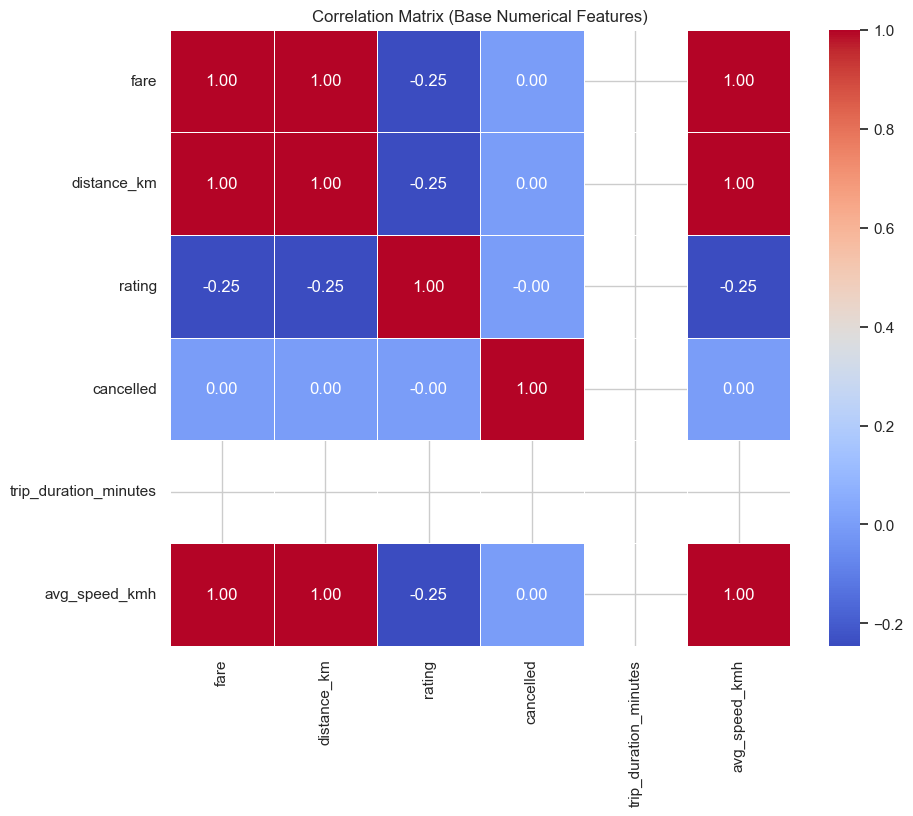

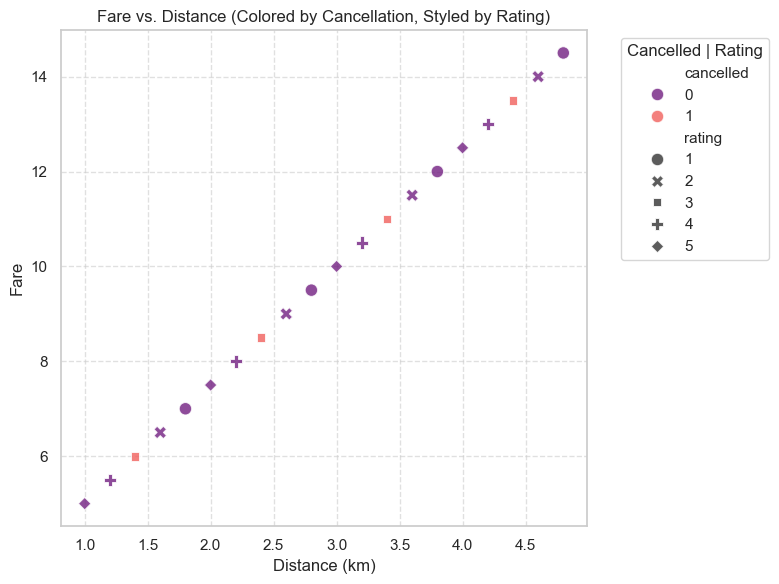

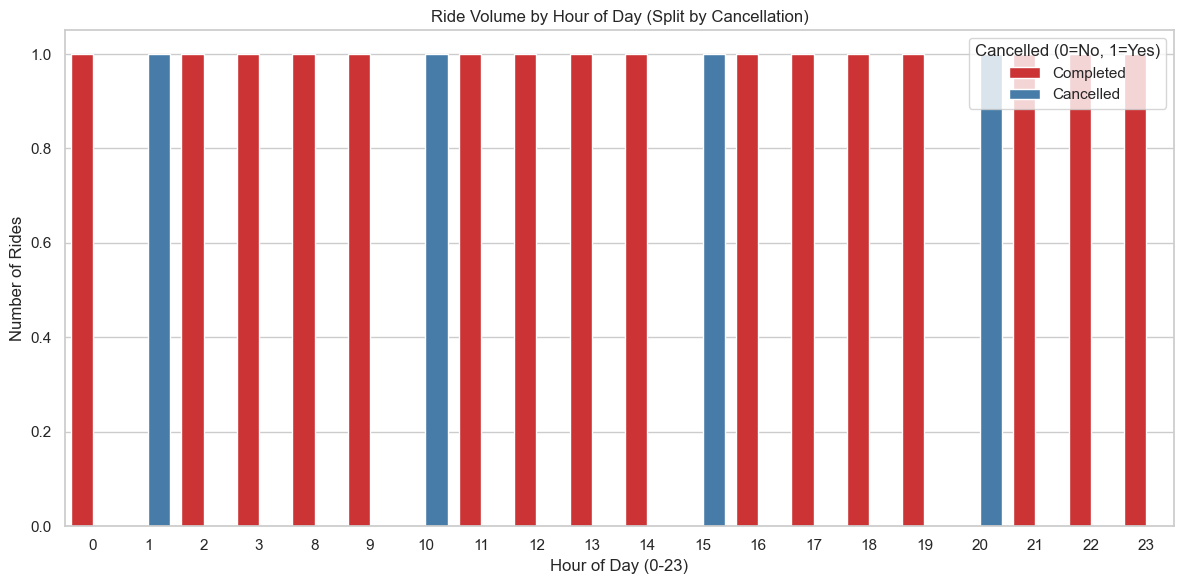

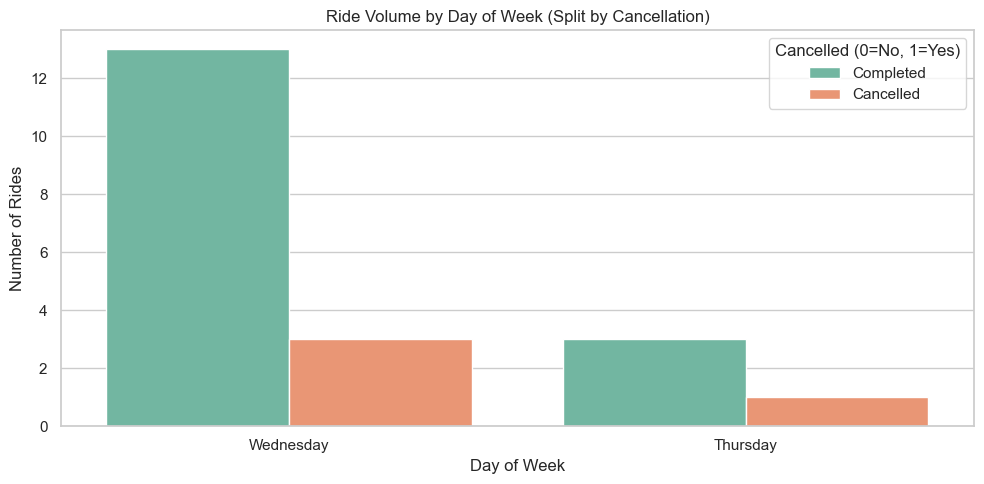

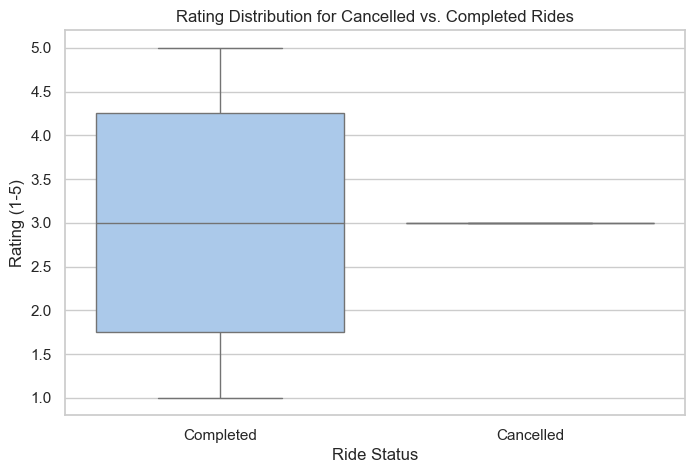

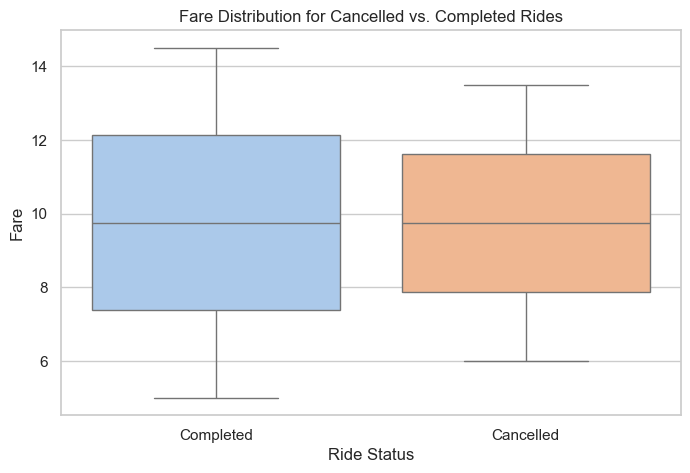

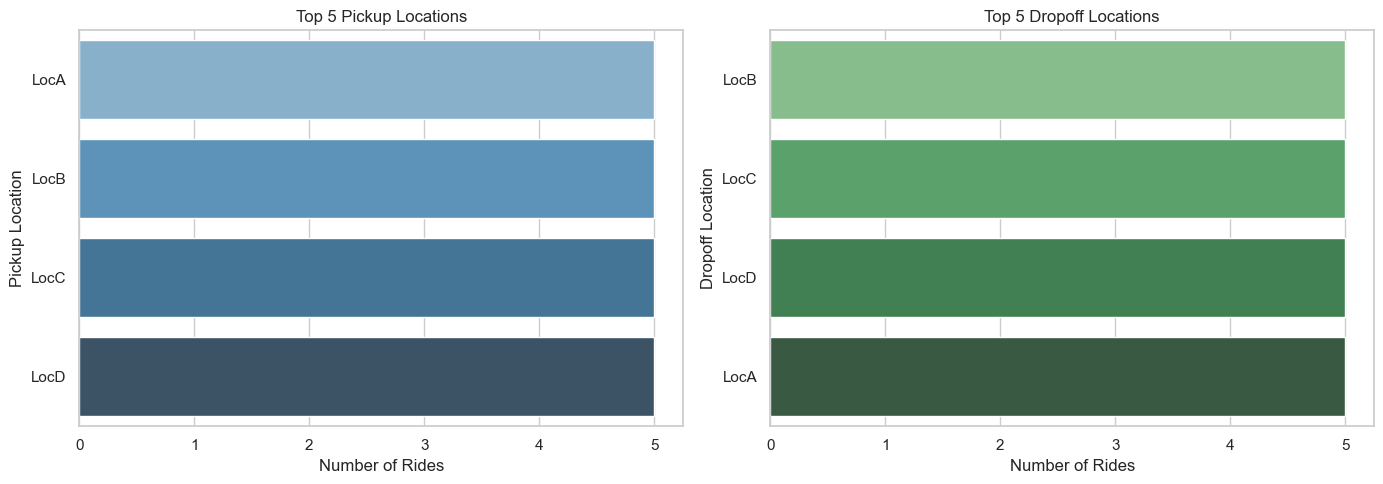


--- Analysis of Engineered Features (Rolling Window & RFM vs. Cancellation) ---
Visualizing rolling features vs cancellation...


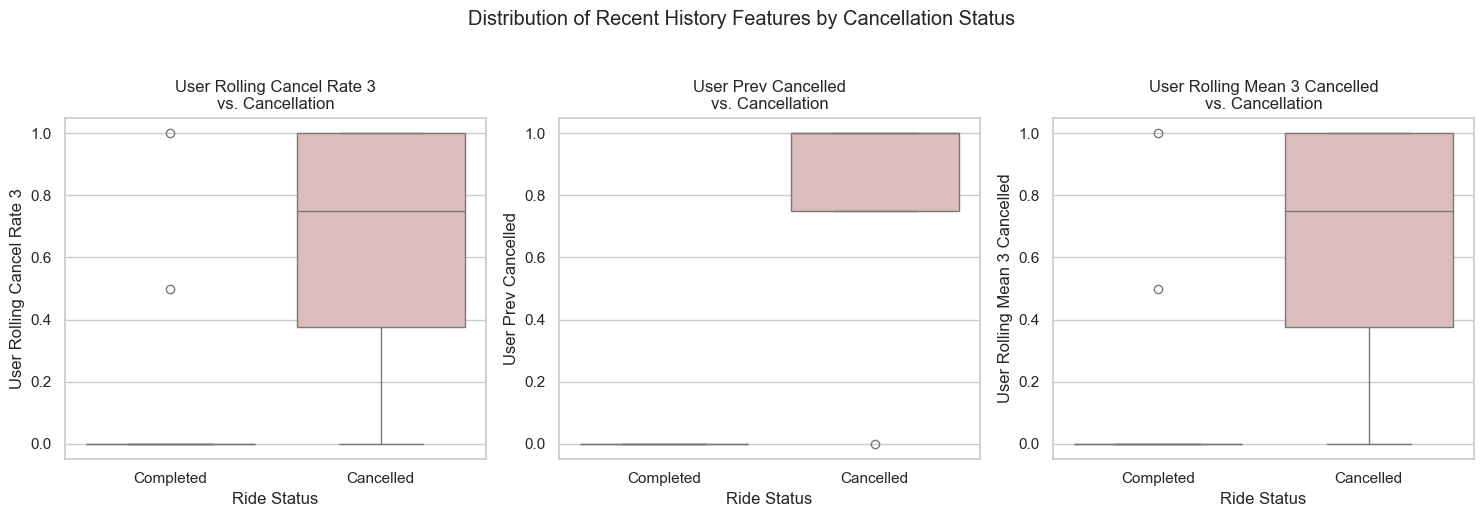


Visualizing user history (RFM-like) features vs cancellation...


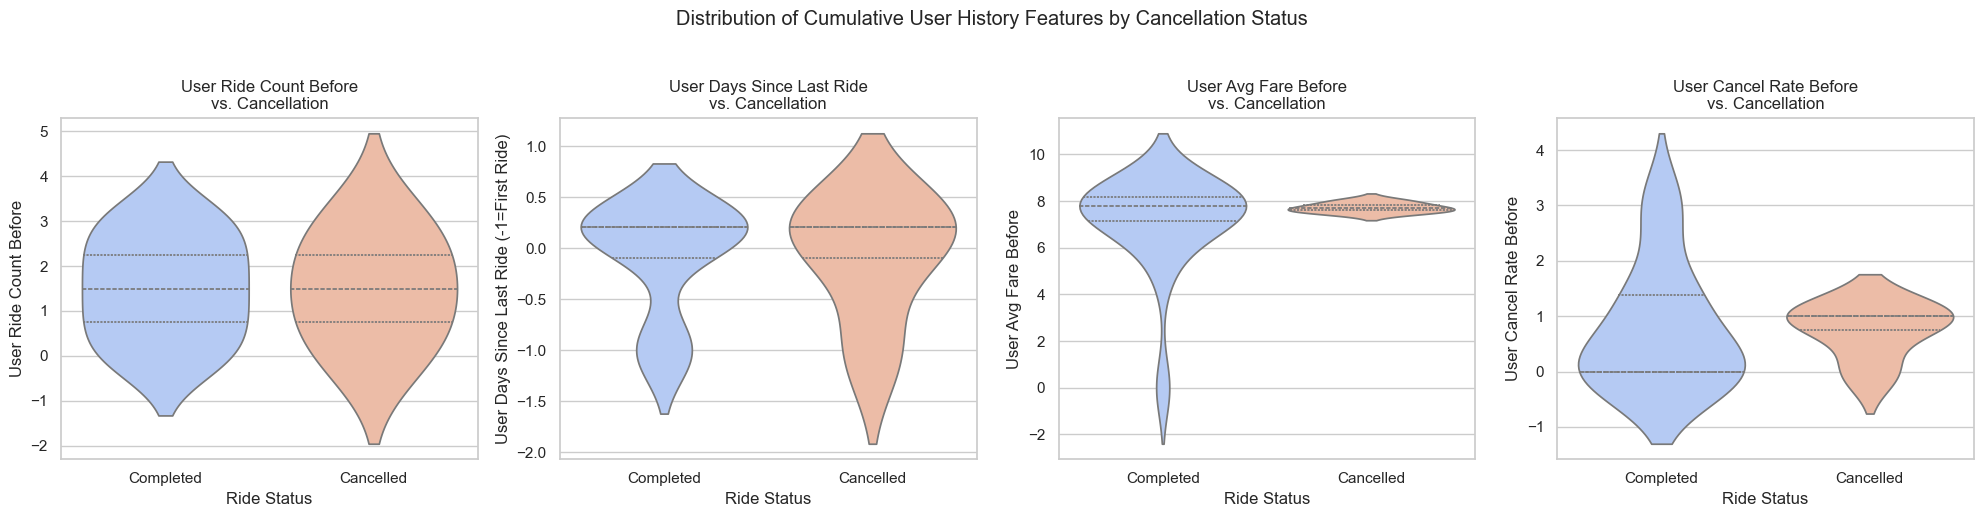


--- Updated Correlation Matrix (Including Engineered Features) ---


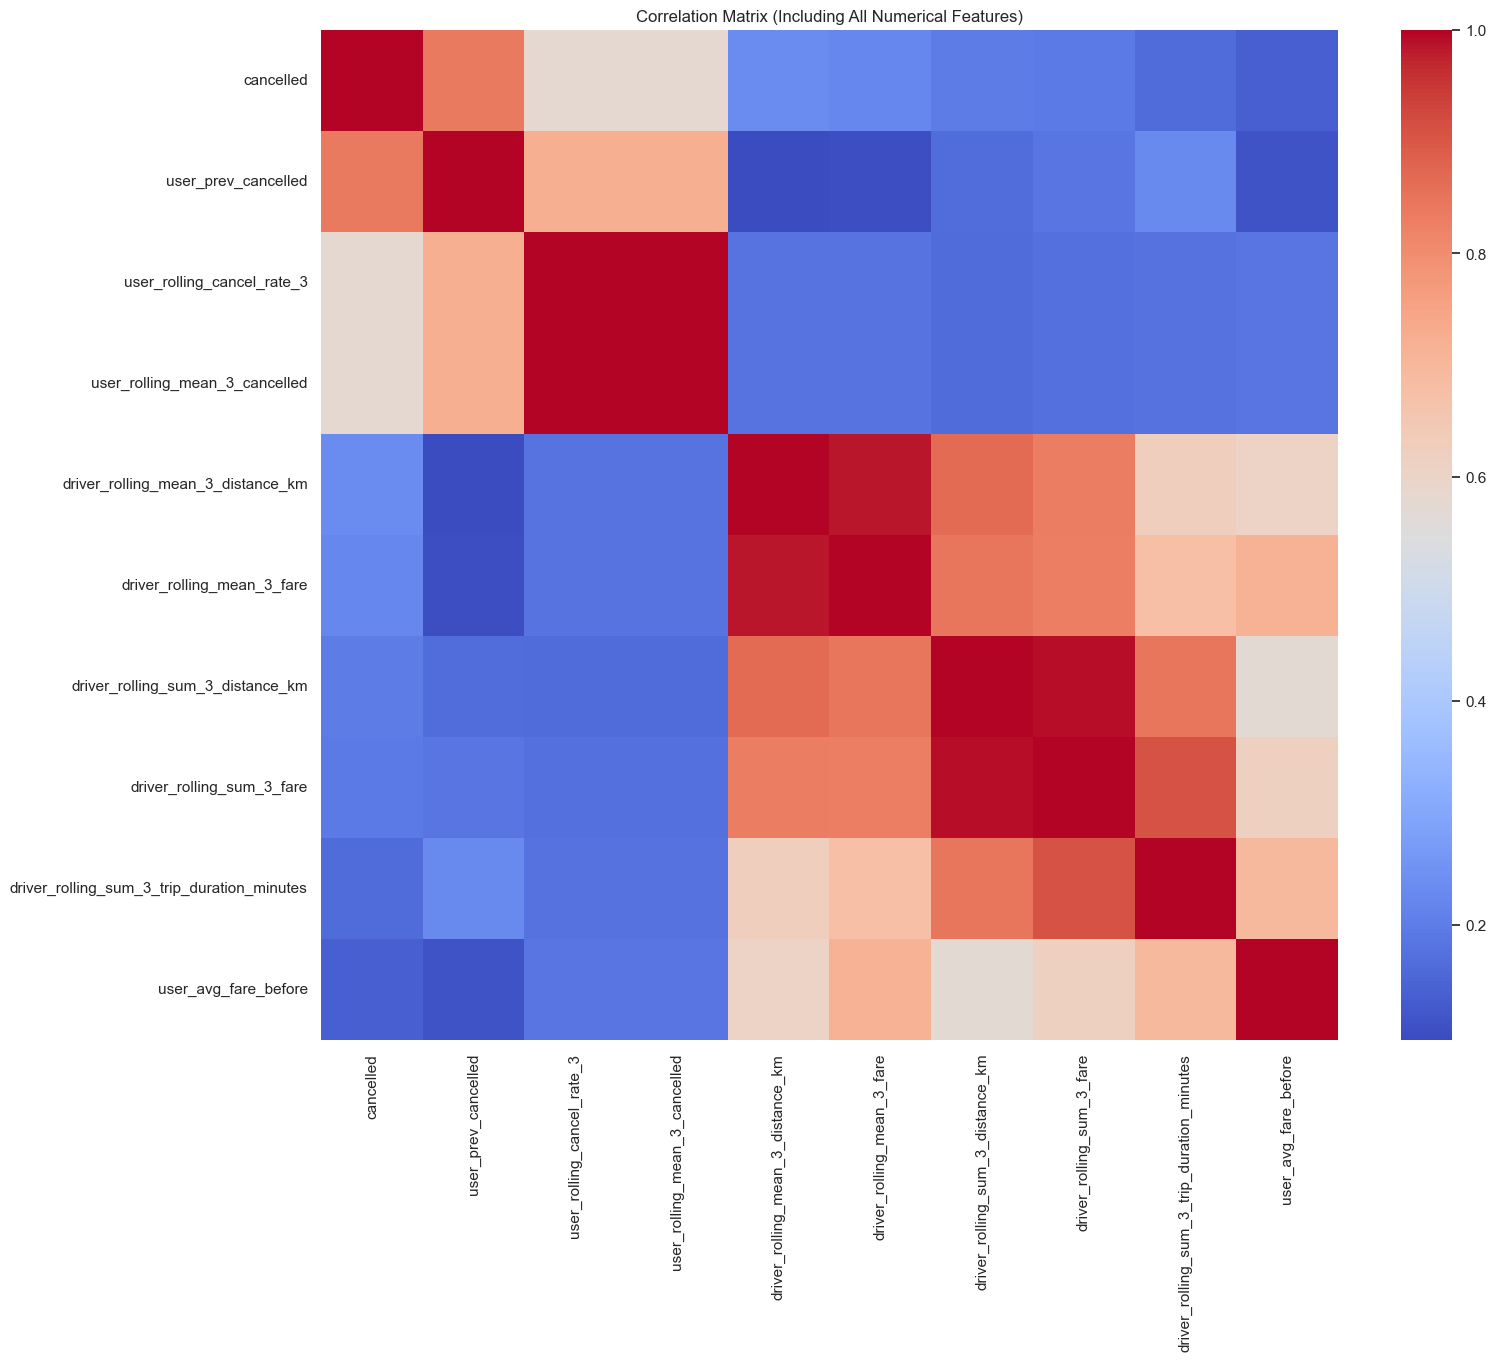


--- Correlation with Target Variable ('cancelled') ---
user_prev_cancelled                            8.401681e-01
user_rolling_cancel_rate_3                     5.783517e-01
user_rolling_mean_3_cancelled                  5.783517e-01
driver_rolling_mean_3_distance_km              2.332606e-01
driver_rolling_mean_3_fare                     2.222912e-01
driver_rolling_sum_3_distance_km               1.961161e-01
driver_rolling_sum_3_fare                      1.936766e-01
driver_rolling_sum_3_trip_duration_minutes     1.630820e-01
user_avg_fare_before                           1.379920e-01
user_rolling_mean_3_fare                       1.213022e-01
user_rolling_mean_3_distance_km                1.148408e-01
driver_rolling_mean_3_trip_duration_minutes    1.147079e-01
user_rolling_mean_3_trip_duration_minutes      1.147079e-01
user_rolling_mean_3_rating                     1.096198e-01
user_rolling_sum_3_trip_duration_minutes       1.071429e-01
user_rolling_sum_3_fare                     

In [ ]:

# --- 6. Multivariate Analysis & Visualization ---

print("\n--- Multivariate Analysis (Relationships between features) ---")

# Correlation between numerical features (start with base features)
base_numeric_cols = ['fare', 'distance_km', 'rating', 'cancelled']

if 'trip_duration_minutes' in df.columns and pd.api.types.is_numeric_dtype(df['trip_duration_minutes']): base_numeric_cols.append('trip_duration_minutes')
if 'avg_speed_kmh' in df.columns and pd.api.types.is_numeric_dtype(df['avg_speed_kmh']): base_numeric_cols.append('avg_speed_kmh')

# Ensure columns exist before calculating correlation
valid_cols_for_corr = [col for col in base_numeric_cols if col in df.columns]
if len(valid_cols_for_corr) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[valid_cols_for_corr].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix (Base Numerical Features)')
    plt.show()
else:
    print("Skipping correlation matrix: Not enough valid numerical columns.")
    correlation_matrix = pd.DataFrame() # Define an empty DataFrame

# Fare vs. Distance - common relationship to check
if 'distance_km' in df.columns and 'fare' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='distance_km', y='fare', hue='cancelled', style='rating', palette='magma', s=80, alpha=0.8)
    plt.title('Fare vs. Distance (Colored by Cancellation, Styled by Rating)')
    plt.xlabel('Distance (km)')
    plt.ylabel('Fare')
    plt.legend(title='Cancelled | Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Ride Volume Over Time (Hourly & Daily, split by cancellation)
if 'start_hour' in df.columns and 'cancelled' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='start_hour', hue='cancelled', palette='Set1', dodge=True, order=sorted(df['start_hour'].unique()))
    plt.title('Ride Volume by Hour of Day (Split by Cancellation)')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Number of Rides')
    plt.legend(title='Cancelled (0=No, 1=Yes)', labels=['Completed', 'Cancelled'])
    plt.tight_layout()
    plt.show()

if 'start_dayname' in df.columns and 'cancelled' in df.columns:
    plt.figure(figsize=(10, 5))
    days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    order = [day for day in days_order if day in df['start_dayname'].unique()]
    sns.countplot(data=df, x='start_dayname', order=order, hue='cancelled', palette='Set2', dodge=True)
    plt.title('Ride Volume by Day of Week (Split by Cancellation)')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Rides')
    plt.legend(title='Cancelled (0=No, 1=Yes)', labels=['Completed', 'Cancelled'])
    plt.tight_layout()
    plt.show()

# Rating & Fare Distribution by Cancellation Status
if 'rating' in df.columns and 'cancelled' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='cancelled', y='rating', palette='pastel')
    plt.title('Rating Distribution for Cancelled vs. Completed Rides')
    plt.xlabel('Ride Status')
    plt.ylabel('Rating (1-5)')
    plt.xticks([0, 1], ['Completed', 'Cancelled'])
    plt.show()

if 'fare' in df.columns and 'cancelled' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='cancelled', y='fare', palette='pastel')
    plt.title('Fare Distribution for Cancelled vs. Completed Rides')
    plt.xlabel('Ride Status')
    plt.ylabel('Fare')
    plt.xticks([0, 1], ['Completed', 'Cancelled'])
    plt.show()

# Top Pickup and Dropoff Locations
n_top = 5 # Show top 5 locations
if 'pickup_location' in df.columns and 'dropoff_location' in df.columns:
    top_pickups_series = df['pickup_location'].value_counts()
    top_dropoffs_series = df['dropoff_location'].value_counts()
    top_pickups = top_pickups_series.nlargest(n_top).index
    top_dropoffs = top_dropoffs_series.nlargest(n_top).index


    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(data=df, y='pickup_location', order=top_pickups, palette='Blues_d')
    plt.title(f'Top {n_top} Pickup Locations')
    plt.xlabel('Number of Rides')
    plt.ylabel('Pickup Location')

    plt.subplot(1, 2, 2)
    sns.countplot(data=df, y='dropoff_location', order=top_dropoffs, palette='Greens_d')
    plt.title(f'Top {n_top} Dropoff Locations')
    plt.xlabel('Number of Rides')
    plt.ylabel('Dropoff Location')

    plt.tight_layout()
    plt.show()
else:
    top_pickups_series = pd.Series() # Define empty series if columns missing
    top_dropoffs_series = pd.Series()

# --- Analysis of Engineered Features (Examples) ---
print("\n--- Analysis of Engineered Features (Rolling Window & RFM vs. Cancellation) ---")

# --- Rolling Features vs. Cancellation ---
rolling_features_to_plot = [
    f'user_rolling_cancel_rate_{window_size}',
    'user_prev_cancelled',
    f'user_rolling_mean_{window_size}_cancelled',
]

print("Visualizing rolling features vs cancellation...")
num_plots = sum(1 for feature in rolling_features_to_plot if feature in df.columns)
if num_plots > 0:
    plt.figure(figsize=(min(15, num_plots * 5), 5)) # Adjust size based on number of plots
    plot_num = 1
    for feature in rolling_features_to_plot:
        if feature in df.columns:
            plt.subplot(1, num_plots, plot_num)
            sns.boxplot(data=df, x='cancelled', y=feature, palette='vlag')
            plt.title(f'{feature.replace("_", " ").title()}\nvs. Cancellation') # Clean up title
            plt.xlabel('Ride Status')
            plt.ylabel(feature.replace("_", " ").title())
            plt.xticks([0, 1], ['Completed', 'Cancelled'])
            plot_num += 1
    plt.suptitle('Distribution of Recent History Features by Cancellation Status', y=1.03)
    plt.tight_layout()
    plt.show()
else:
    print("No rolling features found to plot vs cancellation.")

# --- RFM-like Features vs. Cancellation ---
rfm_features_to_plot = [
    'user_ride_count_before',       # Frequency
    'user_days_since_last_ride',   # Recency (-1 indicates first ride)
    'user_avg_fare_before',        # Monetary (Average)
    'user_cancel_rate_before'      # Behavioral
]
print("\nVisualizing user history (RFM-like) features vs cancellation...")
num_plots = sum(1 for feature in rfm_features_to_plot if feature in df.columns)
if num_plots > 0:
    plt.figure(figsize=(min(20, num_plots * 5), 5)) # Adjust size
    plot_num = 1
    for feature in rfm_features_to_plot:
         if feature in df.columns:
            plt.subplot(1, num_plots, plot_num)
            sns.violinplot(data=df, x='cancelled', y=feature, palette='coolwarm', inner='quartile')
            plt.title(f'{feature.replace("_", " ").title()}\nvs. Cancellation')
            plt.xlabel('Ride Status')
            ylabel_text = feature.replace("_", " ").title()
            if feature == 'user_days_since_last_ride':
                ylabel_text += ' (-1=First Ride)'
            plt.ylabel(ylabel_text)
            plt.xticks([0, 1], ['Completed', 'Cancelled'])
            plot_num += 1
    plt.suptitle('Distribution of Cumulative User History Features by Cancellation Status', y=1.03)
    plt.tight_layout()
    plt.show()
else:
    print("No RFM-like features found to plot vs cancellation.")

# --- Updated Correlation Matrix (Including All Numerical Features) ---
print("\n--- Updated Correlation Matrix (Including Engineered Features) ---")
numerical_cols_updated = df.select_dtypes(include=np.number).columns

cols_for_heatmap = numerical_cols_updated 


heatmap_size = max(15, len(cols_for_heatmap) * 0.4) 
plt.figure(figsize=(heatmap_size, heatmap_size * 0.8))
correlation_matrix_updated = df[cols_for_heatmap].corr()

# Get top 10 features most correlated with 'cancelled'
corr_with_target = correlation_matrix_updated['cancelled'].sort_values(ascending=False)
top_10_cols = corr_with_target.head(10).index

# Filter the correlation matrix for those top 10 columns
filtered_corr_matrix = correlation_matrix_updated.loc[top_10_cols, top_10_cols]


sns.heatmap(filtered_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f") 
plt.title('Correlation Matrix (Including All Numerical Features)')
plt.show()

# Specifically check correlation with the target variable 'cancelled'
print("\n--- Correlation with Target Variable ('cancelled') ---")
if 'cancelled' in correlation_matrix_updated:
    corr_with_target = correlation_matrix_updated['cancelled'].sort_values(ascending=False)

    print(corr_with_target[(corr_with_target < 0.99) & (corr_with_target > -0.99)])
else:
    print("'cancelled' column not found in correlation matrix.")



## 1.7 Summary

In [ ]:

# --- 7. EDA Summary ---
print("\n\n" + "="*50)
print("Part 1: EDA Summary")
print("="*50 + "\n")

print(f"The dataset contains {df.shape[0]} rides and {df.shape[1]} features (after engineering).")
if time_conversion_success:
    min_time, max_time = df['start_time'].min(), df['start_time'].max()
    print(f"Time range of data: {min_time} to {max_time} (Duration: {max_time - min_time})")
else:
     print("Time range not determined due to timestamp conversion issues.")

print("\nData Quality Checks:")
print(f"  - Missing Values: {'None Found' if missing_values.sum() == 0 else f'{missing_values.sum()} Found (in columns: {list(missing_cols.index)})'}")
print(f"  - Duplicate Rows: {'None Found' if duplicate_rows == 0 else f'{duplicate_rows} Found'}")
print(f"  - Timestamps Converted: {'Yes' if time_conversion_success else 'No'}")
if 'rating' in df.columns and pd.api.types.is_numeric_dtype(df['rating']): print(f"  - Ratings within expected 1-5 range: {df['rating'].between(1, 5, inclusive='both').all()}")
if 'cancelled' in df.columns and pd.api.types.is_numeric_dtype(df['cancelled']): print(f"  - 'cancelled' values are 0 or 1: {all(val in [0, 1] for val in df['cancelled'].unique())}")

print("\nKey Observations & Insights (from Sample Data):")

if time_conversion_success and 'trip_duration_minutes' in df.columns:
    print(f"- Trip durations in the sample are constant at {df['trip_duration_minutes'].mean():.0f} minutes. Average speed varies.")
if 'fare' in df.columns and 'distance_km' in df.columns and not correlation_matrix.empty:
    fare_dist_corr = correlation_matrix.loc['fare', 'distance_km'] if ('fare' in correlation_matrix.index and 'distance_km' in correlation_matrix.columns) else 'N/A'
    print(f"- Fare and distance show a strong positive correlation ({fare_dist_corr:.2f}).")
if 'cancelled' in df.columns: print(f"- Overall cancellation rate in the sample: {df['cancelled'].mean()*100:.1f}% ({df['cancelled'].sum()} rides).")
if not top_pickups_series.empty: print(f"- Top pickup locations (sample): {list(top_pickups)}")
if not top_dropoffs_series.empty: print(f"- Top dropoff locations (sample): {list(top_dropoffs)}")
if 'start_hour' in df.columns: print(f"- Demand seems distributed across hours in this small sample (no clear peak).") # Adjust based on plot
if 'start_dayname' in df.columns: print(f"- Rides occurred on {df['start_dayname'].nunique()} distinct days in the sample.") # Adjust based on plot
print("- Engineered features (rolling windows, RFM-like) were created to capture user/driver history.")
print("- Initial visualizations suggest potential (though noisy due to data size) differences in user history (e.g., past cancellation rate, recency) between cancelled and completed rides.")
if not corr_with_target.empty:
    significant_corr = corr_with_target[corr_with_target.abs() > 0.2] # Example threshold
    print(f"- Features with strongest correlation to 'cancelled' in this sample: {list(significant_corr.index)}")
else:
     print("- Correlation with 'cancelled' analysis requires more data or was skipped.")

print("\nLimitations:")
print("- EXTREMELY SMALL SAMPLE SIZE (20 rides): All findings are preliminary and require validation with significantly more data.")
print("- Limited Time Span: Data covers only ~2 days, making long-term behavior analysis impossible.")
print("- Lack of Context: No information on cancellation reasons, traffic, weather, promotions, etc.")

print("\nNext Steps: Proceed to User Behavior Analysis, Predictive Modeling, and Operational Insights, keeping data limitations in mind.")






Part 1: EDA Summary

The dataset contains 20 rides and 50 features (after engineering).
Time range of data: 2025-01-01 08:00:00 to 2025-01-02 03:00:00 (Duration: 0 days 19:00:00)

Data Quality Checks:
  - Missing Values: None Found
  - Duplicate Rows: None Found
  - Timestamps Converted: Yes
  - Ratings within expected 1-5 range: True
  - 'cancelled' values are 0 or 1: True

Key Observations & Insights (from Sample Data):
- Trip durations in the sample are constant at 30 minutes. Average speed varies.
- Fare and distance show a strong positive correlation (1.00).
- Overall cancellation rate in the sample: 20.0% (4 rides).
- Top pickup locations (sample): ['LocA', 'LocB', 'LocC', 'LocD']
- Top dropoff locations (sample): ['LocB', 'LocC', 'LocD', 'LocA']
- Demand seems distributed across hours in this small sample (no clear peak).
- Rides occurred on 2 distinct days in the sample.
- Engineered features (rolling windows, RFM-like) were created to capture user/driver history.
- Initial v

# Part 2. User Behaviour Analysis

In [ ]:
# --- Part 2: User Behavior Analysis ---

print("\n\n" + "="*50)
print("Part 2: User Behavior Analysis")
print("="*50 + "\n")


required_cols_part2 = ['ride_id', 'user_id', 'driver_id', 'start_time', 'fare', 'cancelled', 'rating']
if not all(col in df.columns for col in required_cols_part2):
    print(f"Error: DataFrame 'df' is missing one or more required columns for Part 2: {required_cols_part2}. Aborting Part 2.")

    user_summary = pd.DataFrame() 
    segmentation_possible = False 
else:

    try:
        if not pd.api.types.is_numeric_dtype(df['rating']): df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
        if not pd.api.types.is_numeric_dtype(df['cancelled']): df['cancelled'] = pd.to_numeric(df['cancelled'], errors='coerce')
        if not pd.api.types.is_datetime64_any_dtype(df['start_time']): df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
        print("Checked/converted types for user analysis.")
    except Exception as e:
        print(f"Warning: Could not ensure correct data types for user analysis - {e}")



Part 2: User Behavior Analysis

Checked/converted types for user analysis.


## 2.1 User Segmentation by Ride Frequency and Spending


--- 2.1 User Segmentation (Frequency & Spending) ---
Calculated 'recency_hours' relative to 2025-01-02 03:00:00.
Total unique users: 5
User segments created based on frequency and spending quantiles.

User Summary DataFrame with Segments:
  user_id  total_rides  total_spending  recency_hours  cancellation_rate  \
0      U1            4            35.0            4.0                0.0   
1      U2            4            37.0            3.0                0.0   
2      U3            4            39.0            2.0                1.0   
3      U4            4            41.0            1.0                0.0   
4      U5            4            43.0            0.0                0.0   

   low_rating_rate                    user_segment  
0              0.0            Low Freq - Low Spend  
1              0.0            Low Freq - Low Spend  
2              0.0    Med-Low Freq - Med-Low Spend  
3              1.0  Med-High Freq - Med-High Spend  
4              1.0          High Freq 

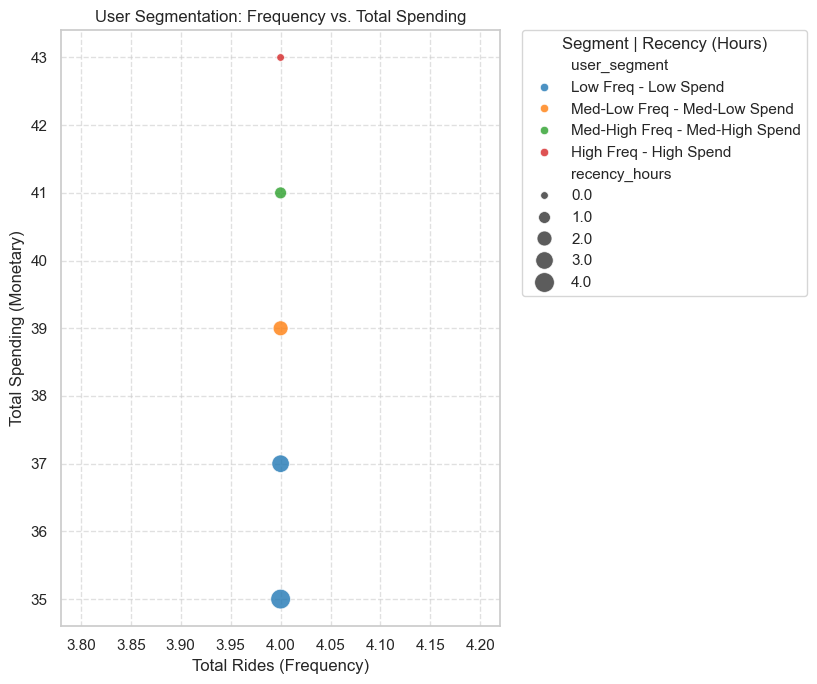

In [ ]:



    # --- 2.1 User Segmentation by Ride Frequency and Spending ---

    print("\n--- 2.1 User Segmentation (Frequency & Spending) ---")

    # Aggregate data at the user level

    agg_dict = {
        'total_rides': ('ride_id', 'count'),
        'total_spending': ('fare', 'sum'),
        'avg_spending': ('fare', 'mean'),
        'first_ride_time': ('start_time', 'min'),
        'last_ride_time': ('start_time', 'max'),
        'total_cancelled': ('cancelled', lambda x: x.dropna().eq(1).sum()), # Sum where cancelled == 1
        'total_low_ratings': ('rating', lambda x: x.dropna().le(2).sum()), # Count ratings <= 2 (example threshold)
        'avg_rating': ('rating', 'mean')
    }


    if not pd.api.types.is_datetime64_any_dtype(df['start_time']):
        agg_dict.pop('first_ride_time', None); agg_dict.pop('last_ride_time', None)
        print("Warning: Cannot calculate first/last ride times.")
    if 'cancelled' not in df.columns or not pd.api.types.is_numeric_dtype(df['cancelled']):
        agg_dict.pop('total_cancelled', None)
        print("Warning: Cannot calculate total cancellations.")
    if 'rating' not in df.columns or not pd.api.types.is_numeric_dtype(df['rating']):
        agg_dict.pop('total_low_ratings', None); agg_dict.pop('avg_rating', None)
        print("Warning: Cannot calculate rating metrics.")

    try:
        user_summary = df.groupby('user_id').agg(**agg_dict).reset_index()

        # --- Calculate Recency ---

        if 'last_ride_time' in user_summary.columns and pd.api.types.is_datetime64_any_dtype(user_summary['last_ride_time']):
            max_time_in_data = df['start_time'].max() # Use max start_time as observation end
            if pd.notna(max_time_in_data):
                time_diff = max_time_in_data - user_summary['last_ride_time']
                # Use fractional days for more granularity with short datasets
                user_summary['recency_hours'] = time_diff.dt.total_seconds() / 3600
                print(f"Calculated 'recency_hours' relative to {max_time_in_data}.")
                user_summary['last_ride_date'] = user_summary['last_ride_time'].dt.date # Keep date for churn check
            else:
                user_summary['recency_hours'] = np.nan
                user_summary['last_ride_date'] = pd.NaT
                print("Skipping recency calculation (max time unknown).")
        else:
            user_summary['recency_hours'] = np.nan
            user_summary['last_ride_date'] = pd.NaT
            print("Skipping recency calculation (last ride time unknown).")

        # --- Calculate User-Level Rates ---
        low_rating_threshold = 2 # Define what constitutes a 'low' rating
        if 'total_cancelled' in user_summary.columns and 'total_rides' in user_summary.columns:
            user_summary['cancellation_rate'] = (user_summary['total_cancelled'] / user_summary['total_rides']).fillna(0)
        else: user_summary['cancellation_rate'] = np.nan

        if 'total_low_ratings' in user_summary.columns and 'total_rides' in user_summary.columns:
            user_summary['low_rating_rate'] = (user_summary['total_low_ratings'] / user_summary['total_rides']).fillna(0)
        else: user_summary['low_rating_rate'] = np.nan


        # --- Define Segments using Quantiles (Robust Handling) ---

        n_users = user_summary.shape[0]
        print(f"Total unique users: {n_users}")
        segmentation_possible = n_users >= 4 # Basic check for 4 quantiles

        if segmentation_possible:
            freq_labels = ['Low Freq', 'Med-Low Freq', 'Med-High Freq', 'High Freq']
            spend_labels = ['Low Spend', 'Med-Low Spend', 'Med-High Spend', 'High Spend']
            try:
                # Use duplicates='drop' in case of ties at quantile boundaries
                user_summary['freq_segment'] = pd.qcut(user_summary['total_rides'], q=4, labels=freq_labels, duplicates='drop')
            except ValueError: # Might happen if too many ties prevent unique bins
                 print("Warning: Could not create 4 unique frequency bins due to ties. Attempting rank-based segmentation.")
                 try: # Fallback: rank first, then cut
                     user_summary['freq_segment'] = pd.qcut(user_summary['total_rides'].rank(method='first'), q=4, labels=freq_labels, duplicates='drop')
                 except Exception as e:
                     print(f"Error: Frequency segmentation failed even with ranking: {e}")
                     user_summary['freq_segment'] = 'Segmentation Failed'
                     segmentation_possible = False # Mark as failed


            if segmentation_possible:
                try:
                    user_summary['spend_segment'] = pd.qcut(user_summary['total_spending'], q=4, labels=spend_labels, duplicates='drop')
                except ValueError:
                    print("Warning: Could not create 4 unique spending bins due to ties. Attempting rank-based segmentation.")
                    try:
                        user_summary['spend_segment'] = pd.qcut(user_summary['total_spending'].rank(method='first'), q=4, labels=spend_labels, duplicates='drop')
                    except Exception as e:
                        print(f"Error: Spending segmentation failed even with ranking: {e}")
                        user_summary['spend_segment'] = 'Segmentation Failed'
                        segmentation_possible = False # Mark as failed


            if segmentation_possible and 'freq_segment' in user_summary.columns and 'spend_segment' in user_summary.columns \
               and user_summary['freq_segment'].iloc[0] != 'Segmentation Failed' \
               and user_summary['spend_segment'].iloc[0] != 'Segmentation Failed':
                 user_summary['user_segment'] = user_summary['freq_segment'].astype(str) + ' - ' + user_summary['spend_segment'].astype(str)
                 print("User segments created based on frequency and spending quantiles.")
            else:
                 # Ensure columns exist even if failed, set segment to N/A
                 if 'freq_segment' not in user_summary.columns: user_summary['freq_segment'] = 'N/A'
                 if 'spend_segment' not in user_summary.columns: user_summary['spend_segment'] = 'N/A'
                 user_summary['user_segment'] = 'N/A'
                 segmentation_possible = False # Ensure flag is false if combination failed
                 print("Could not create combined user segments.")
        else:

            user_summary['freq_segment'] = 'Single Group'
            user_summary['spend_segment'] = 'Single Group'
            user_summary['user_segment'] = 'N/A'
            print("Not enough users for quantile-based segmentation.")


        print("\nUser Summary DataFrame with Segments:")
        display_cols = ['user_id', 'total_rides', 'total_spending', 'recency_hours', 'cancellation_rate', 'low_rating_rate', 'user_segment']
        print(user_summary[[col for col in display_cols if col in user_summary.columns]].head())

        # --- Visualize Segments ---

        if segmentation_possible and 'user_segment' in user_summary.columns and user_summary['user_segment'].nunique() > 1 and user_summary['user_segment'].iloc[0] != 'N/A':
            print("\nSegment Counts:")
            print(user_summary['user_segment'].value_counts())

            plt.figure(figsize=(10, 7))
            # Size points by recency (more recent = smaller point, invert scale if needed)
            # Use total_rides vs total_spending as axes
            sns.scatterplot(data=user_summary, x='total_rides', y='total_spending', hue='user_segment',
                            size='recency_hours', # Smaller value (more recent) can be smaller dot
                            sizes=(30, 200), alpha=0.8, palette='tab10', legend='full')
            plt.title('User Segmentation: Frequency vs. Total Spending')
            plt.xlabel('Total Rides (Frequency)')
            plt.ylabel('Total Spending (Monetary)')
            # Adjust legend position
            plt.legend(title='Segment | Recency (Hours)', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
            plt.show()
        else:
            print("Skipping segment visualization (segmentation failed, only one segment, or too few users).")

    except Exception as e:
        print(f"An error occurred during user summary aggregation or segmentation: {e}")
        user_summary = pd.DataFrame() 
        segmentation_possible = False 



## 2.2 Analyze Trends in Cancellations and Low Ratings


--- 2.2 Analysis of Cancellations and Low Ratings ---
Overall Ride Cancellation Rate: 20.00%
Overall Low Rating (<= 2) Rate: 40.00%

Average Metrics by User Segment:
                     user_segment  avg_cancellation_rate  avg_low_rating_rate  \
3    Med-Low Freq - Med-Low Spend                    1.0                  0.0   
0          High Freq - High Spend                    0.0                  1.0   
1            Low Freq - Low Spend                    0.0                  0.0   
2  Med-High Freq - Med-High Spend                    0.0                  1.0   

   avg_recency_hours  user_count  
3                2.0           1  
0                0.0           1  
1                3.5           2  
2                1.0           1  


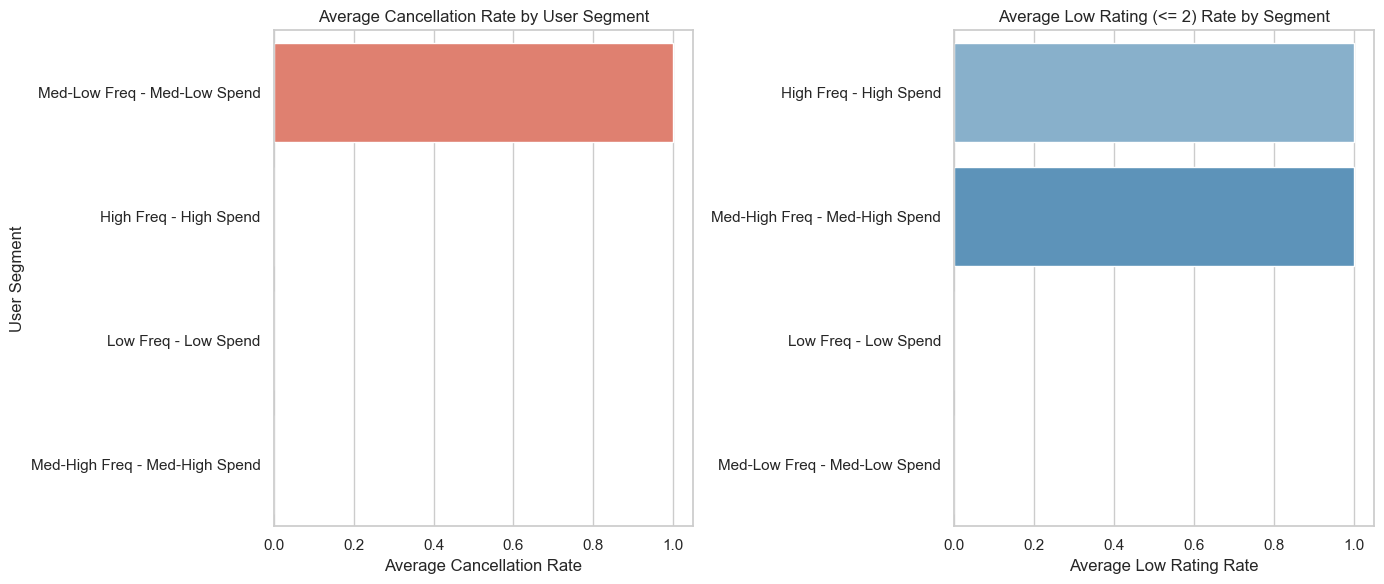

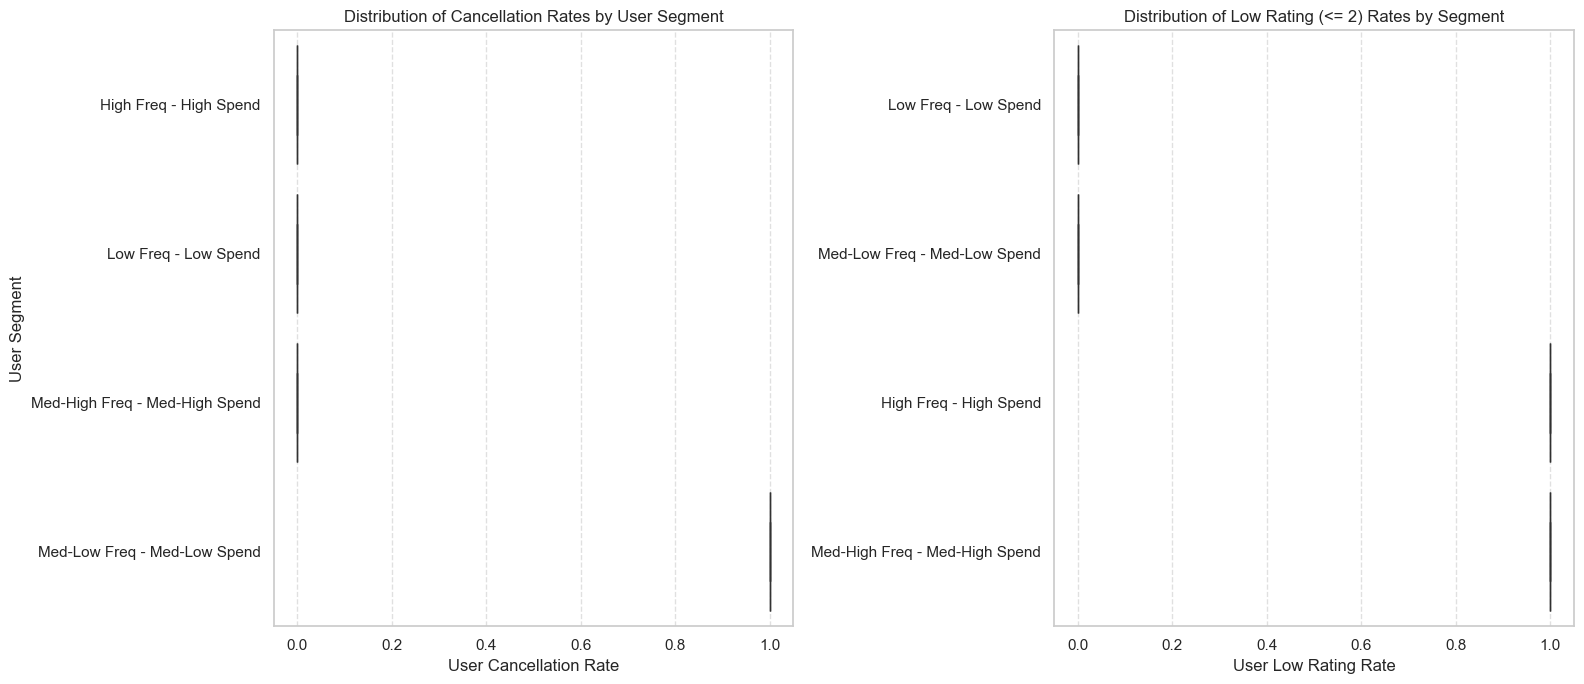


Correlation of User Summary Metrics:


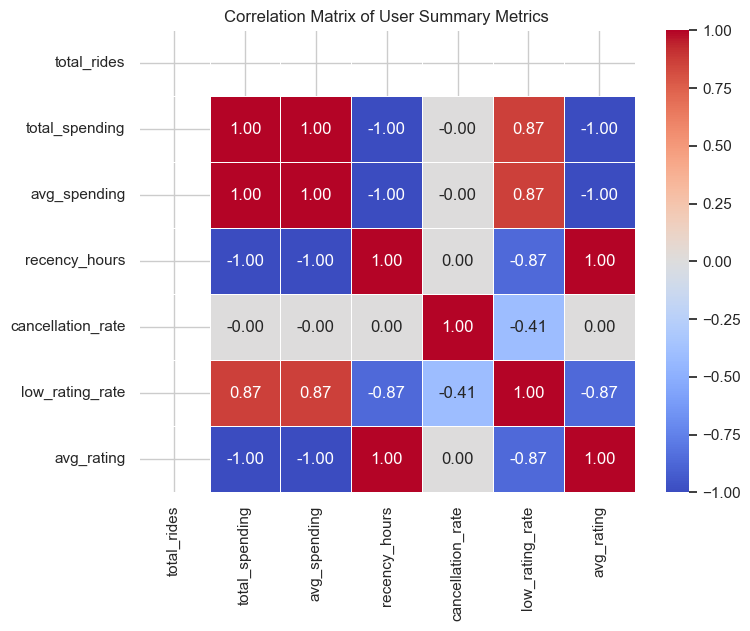


Correlations with Cancellation Rate:
low_rating_rate   -4.082483e-01
total_spending    -9.813078e-18
avg_spending      -9.813078e-18
recency_hours      9.813078e-18
avg_rating         0.000000e+00
total_rides                 NaN
Name: cancellation_rate, dtype: float64

Correlations with Low Rating (<= 2) Rate:
total_spending       0.866025
avg_spending         0.866025
recency_hours       -0.866025
avg_rating          -0.866025
cancellation_rate   -0.408248
total_rides               NaN
Name: low_rating_rate, dtype: float64


In [ ]:

    # --- 2.2 Analyze Trends in Cancellations and Low Ratings ---
    if not user_summary.empty:
        print("\n--- 2.2 Analysis of Cancellations and Low Ratings ---")

        # Calculate overall rates from the original dataframe for comparison
        overall_cancel_rate = df['cancelled'].mean() if 'cancelled' in df.columns and pd.api.types.is_numeric_dtype(df['cancelled']) else np.nan
        overall_low_rating_rate = (df['rating'] <= low_rating_threshold).mean() if 'rating' in df.columns and pd.api.types.is_numeric_dtype(df['rating']) else np.nan

        print(f"Overall Ride Cancellation Rate: {overall_cancel_rate:.2%}" if pd.notna(overall_cancel_rate) else "Overall Cancellation rate N/A")
        print(f"Overall Low Rating (<= {low_rating_threshold}) Rate: {overall_low_rating_rate:.2%}" if pd.notna(overall_low_rating_rate) else "Overall Low rating rate N/A")

        # --- Rates per User Segment ---

        if segmentation_possible and 'user_segment' in user_summary.columns and user_summary['user_segment'].nunique() > 1 and user_summary['user_segment'].iloc[0] != 'N/A':
            # Ensure required columns for aggregation exist
            agg_cols_segment = ['cancellation_rate', 'low_rating_rate', 'recency_hours', 'user_id']
            valid_agg_cols = {
                f'avg_{col}': (col, 'mean') for col in agg_cols_segment[:-1] if col in user_summary.columns
            }
            valid_agg_cols['user_count'] = ('user_id', 'count') # Always include count

            if len(valid_agg_cols) > 1: # Need more than just count
                segment_analysis = user_summary.groupby('user_segment').agg(
                    **valid_agg_cols
                ).reset_index()
                print("\nAverage Metrics by User Segment:")
                # Sort by a meaningful metric if available, e.g., cancel rate
                sort_col = 'avg_cancellation_rate' if 'avg_cancellation_rate' in segment_analysis.columns else 'user_count'
                print(segment_analysis.sort_values(by=sort_col, ascending=False))

                # --- Visualize Segment Differences ---
                plt.figure(figsize=(14, 6))
                plot_count = 0

                if 'avg_cancellation_rate' in segment_analysis.columns:
                    plot_count += 1
                    plt.subplot(1, 2, plot_count)
                    sns.barplot(data=segment_analysis, x='avg_cancellation_rate', y='user_segment', palette='Reds_d', order=segment_analysis.sort_values('avg_cancellation_rate', ascending=False)['user_segment'])
                    plt.title('Average Cancellation Rate by User Segment')
                    plt.xlabel('Average Cancellation Rate')
                    plt.ylabel('User Segment' if plot_count == 1 else '')


                if 'avg_low_rating_rate' in segment_analysis.columns:
                    plot_count += 1
                    plt.subplot(1, 2, plot_count)
                    sns.barplot(data=segment_analysis, x='avg_low_rating_rate', y='user_segment', palette='Blues_d', order=segment_analysis.sort_values('avg_low_rating_rate', ascending=False)['user_segment'])
                    plt.title(f'Average Low Rating (<= {low_rating_threshold}) Rate by Segment')
                    plt.xlabel(f'Average Low Rating Rate')
                    plt.ylabel('User Segment' if plot_count == 1 else '')

                if plot_count > 0:
                    plt.tight_layout()
                    plt.show()
                else:
                    print("Skipping segment rate bar plots (required columns missing).")


                # Box Plot for Distribution of Rates within Segments
                plt.figure(figsize=(16, 7))
                plot_count = 0

                if 'cancellation_rate' in user_summary.columns:
                    plot_count += 1
                    plt.subplot(1, 2, plot_count)
                    order_cancel = user_summary.groupby('user_segment')['cancellation_rate'].median().sort_values().index
                    sns.boxplot(data=user_summary, x='cancellation_rate', y='user_segment', order=order_cancel, palette='Reds_d')
                    plt.title('Distribution of Cancellation Rates by User Segment')
                    plt.xlabel('User Cancellation Rate')
                    plt.ylabel('User Segment' if plot_count == 1 else '')
                    plt.grid(True, axis='x', linestyle='--', alpha=0.6)

                # Plot Low Rating Rate distribution if available
                if 'low_rating_rate' in user_summary.columns:
                     plot_count += 1
                     plt.subplot(1, 2, plot_count)
                     order_rating = user_summary.groupby('user_segment')['low_rating_rate'].median().sort_values().index
                     sns.boxplot(data=user_summary, x='low_rating_rate', y='user_segment', order=order_rating, palette='Blues_d')
                     plt.title(f'Distribution of Low Rating (<= {low_rating_threshold}) Rates by Segment')
                     plt.xlabel(f'User Low Rating Rate')
                     plt.ylabel('User Segment' if plot_count == 1 else '')
                     plt.grid(True, axis='x', linestyle='--', alpha=0.6)

                if plot_count > 0:
                    plt.tight_layout()
                    plt.show()
                else:
                     print("Skipping segment rate box plots (required columns missing).")

            else:
                print("Skipping segment-based rate analysis (required columns missing from user_summary).")
        else:
            print("Skipping segment-based rate analysis (segmentation not possible or only one segment).")

        # --- Correlation between user summary metrics ---
        print("\nCorrelation of User Summary Metrics:")
        user_metrics_for_corr = ['total_rides', 'total_spending', 'avg_spending', 'recency_hours', 'cancellation_rate', 'low_rating_rate', 'avg_rating']

        valid_user_metrics = [col for col in user_metrics_for_corr if col in user_summary.columns and pd.api.types.is_numeric_dtype(user_summary[col]) and user_summary[col].notna().any()]

        if len(valid_user_metrics) > 1:
            user_metrics_corr = user_summary[valid_user_metrics].corr()
            plt.figure(figsize=(8, 6))
            sns.heatmap(user_metrics_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
            plt.title('Correlation Matrix of User Summary Metrics')
            plt.show()


            if 'cancellation_rate' in user_metrics_corr:
                print("\nCorrelations with Cancellation Rate:")

                print(user_metrics_corr['cancellation_rate'].drop('cancellation_rate', errors='ignore').sort_values(key=abs, ascending=False))
            if 'low_rating_rate' in user_metrics_corr:
                print(f"\nCorrelations with Low Rating (<= {low_rating_threshold}) Rate:")

                print(user_metrics_corr['low_rating_rate'].drop('low_rating_rate', errors='ignore').sort_values(key=abs, ascending=False))
        else:
            print("Skipping user metrics correlation matrix (not enough valid numeric metrics).")
            user_metrics_corr = pd.DataFrame() 

## 2.3 Churn Indicators


--- 2.3 Churn Indicator Analysis ---
NOTE: 'Churn' here means inactivity within the short observation period.
Last calendar date recorded in the dataset: 2025-01-02
Number of potentially churned users (last ride before 2025-01-02): 1 out of 5 (20.0%)
Users potentially churned:
  user_id last_ride_date  recency_hours  total_rides
0      U1     2025-01-01            4.0            4

Comparison of Active vs. Potentially Churned Users:
      potential_churn  avg_total_rides  avg_total_spending  avg_recency_hours  \
0              Active              4.0                40.0                1.5   
1  Churned (Inactive)              4.0                35.0                4.0   

   avg_cancel_rate  avg_low_rating_rate  median_avg_rating  user_count  
0             0.25                  0.5                2.5           4  
1             0.00                  0.0                5.0           1  


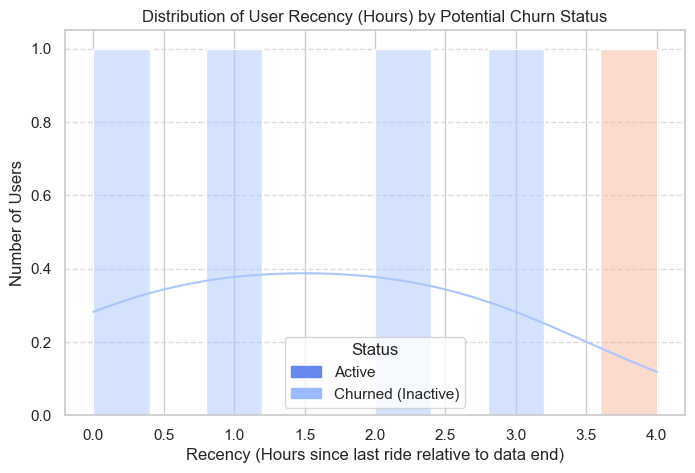

In [ ]:
# --- 2.3 Identify Churn Indicators ---

if not user_summary.empty and 'last_ride_date' in user_summary.columns and pd.api.types.is_datetime64_any_dtype(df['start_time']):
    print("\n--- 2.3 Churn Indicator Analysis ---")
    print("NOTE: 'Churn' here means inactivity within the short observation period.")

    last_date_in_data = df['start_time'].dt.date.max()
    if pd.notna(last_date_in_data):
        print(f"Last calendar date recorded in the dataset: {last_date_in_data}")


        user_summary['potential_churn'] = (user_summary['last_ride_date'].notna()) & (user_summary['last_ride_date'] < last_date_in_data)

        churned_count = user_summary['potential_churn'].sum()
        total_users = user_summary.shape[0]
        if total_users > 0:
            churn_rate = churned_count / total_users if total_users > 0 else 0
            print(f"Number of potentially churned users (last ride before {last_date_in_data}): {churned_count} out of {total_users} ({churn_rate:.1%})")
            if churned_count > 0:
                    print("Users potentially churned:")
                    churn_display_cols = ['user_id', 'last_ride_date', 'recency_hours', 'total_rides']
                    print(user_summary.loc[user_summary['potential_churn'], [c for c in churn_display_cols if c in user_summary.columns]])
            else:
                    print("No users identified as potentially churned based on this definition.")

            # --- Compare Characteristics of Churned vs. Active ---
            if user_summary['potential_churn'].nunique() > 1: 

                churn_agg_cols = {
                    'avg_total_rides': ('total_rides', 'mean'),
                    'avg_total_spending': ('total_spending', 'mean'),
                    'avg_recency_hours': ('recency_hours', 'mean'),
                    'avg_cancel_rate': ('cancellation_rate', 'mean'),
                    'avg_low_rating_rate': ('low_rating_rate', 'mean'),
                    'median_avg_rating': ('avg_rating', 'median'),
                    'user_count': ('user_id', 'count')
                }

                valid_churn_agg = {k: v for k, v in churn_agg_cols.items() if v[0] in user_summary.columns}

                if len(valid_churn_agg) > 1: 
                    churn_comparison = user_summary.groupby('potential_churn').agg(**valid_churn_agg).reset_index()

                    churn_comparison['potential_churn'] = churn_comparison['potential_churn'].map({True: 'Churned (Inactive)', False: 'Active'})
                    print("\nComparison of Active vs. Potentially Churned Users:")
                    print(churn_comparison)


                    if 'recency_hours' in user_summary.columns:
                        plt.figure(figsize=(8, 5))
                        sns.histplot(data=user_summary, x='recency_hours', hue='potential_churn', kde=True, bins=10, palette='coolwarm')
                        plt.title('Distribution of User Recency (Hours) by Potential Churn Status')
                        plt.xlabel('Recency (Hours since last ride relative to data end)')
                        plt.ylabel('Number of Users')

                        handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette('coolwarm')[i]) for i in range(user_summary['potential_churn'].nunique())]
                        labels = ['Active', 'Churned (Inactive)'] if user_summary['potential_churn'].nunique() > 1 else ['Active'] # Adjust based on actual values
                        plt.legend(handles, labels, title='Status')
                        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
                        plt.show()
                    else:
                        print("Skipping recency distribution plot (recency_hours missing).")
                else:
                    print("Skipping churn comparison (required columns missing).")
                    churn_comparison = pd.DataFrame() 

            else:
                    print("\nCannot compare churned vs active users - all users fall into one category (or only one user).")
                    churn_comparison = pd.DataFrame()
        else:
            print("No users to analyze for churn.")
    else:
        print("Skipping churn analysis (last date in data unknown).")
        churn_comparison = pd.DataFrame() 
        churned_count = 0; total_users = 0 

else:
    print("\nSkipping Churn Indicator Analysis (missing user summary, last ride date, or valid start times).")
    churn_comparison = pd.DataFrame() 
    churned_count = 0; total_users = 0




## 2.4 User Behavior Analysis Summary 

In [ ]:

# --- User Behavior Analysis Summary ---
print("\n--- User Behavior Analysis Summary ---")
if not user_summary.empty:

    if segmentation_possible and 'user_segment' in user_summary.columns and user_summary['user_segment'].nunique() > 1:
        print(f"- Users segmented into {user_summary['user_segment'].nunique()} groups based on ride frequency and spending.")

        if 'segment_analysis' in locals() and not segment_analysis.empty and 'avg_cancellation_rate' in segment_analysis.columns:
                segment_analysis_sorted = segment_analysis.sort_values('avg_cancellation_rate', ascending=False)
                print(f"  - Segment '{segment_analysis_sorted.iloc[0]['user_segment']}' shows the highest average cancellation rate ({segment_analysis_sorted.iloc[0]['avg_cancellation_rate']:.2%}).")
    else: print("- User segmentation was limited due to data size or ties.")

    if pd.notna(overall_cancel_rate): print(f"- Overall cancellation rate: {overall_cancel_rate:.2%}. User-level rates vary.")
    if pd.notna(overall_low_rating_rate): print(f"- Overall low rating (<= {low_rating_threshold}) rate: {overall_low_rating_rate:.2%}. User-level rates vary.")


    if 'user_metrics_corr' in locals() and not user_metrics_corr.empty and 'cancellation_rate' in user_metrics_corr and 'recency_hours' in user_metrics_corr:
            rec_cancel_corr = user_metrics_corr.loc['recency_hours', 'cancellation_rate']
            print(f"- User recency (hours since last ride) shows a correlation of {rec_cancel_corr:.2f} with their overall cancellation rate in this sample.")

    if 'potential_churn' in user_summary.columns and total_users > 0:
        churn_rate_summary = churned_count / total_users if total_users > 0 else 0
        print(f"- Potential churn indicators identified based on inactivity before {last_date_in_data if 'last_date_in_data' in locals() else 'end of data'}: {churned_count} users ({churn_rate_summary:.1%}).")
        if 'churn_comparison' in locals() and not churn_comparison.empty:

            diff_text = []
            if 'avg_recency_hours' in churn_comparison.columns: diff_text.append("recency")
            if 'avg_total_spending' in churn_comparison.columns: diff_text.append("spending")
            if diff_text:
                    print(f"- Comparison suggests potentially churned users might differ in {', '.join(diff_text)} (needs more data).")
            else:
                    print("- Churn comparison performed, but significant differences not immediately obvious in summary stats.")
        elif total_users > 0 and user_summary['potential_churn'].nunique() <= 1:
                print("- Churn comparison skipped (all users active/inactive).")
    else: print("- Churn analysis skipped due to data limitations.")
else: print("- User Behavior Analysis skipped due to errors in data preparation or aggregation.")






--- User Behavior Analysis Summary ---
- Users segmented into 4 groups based on ride frequency and spending.
  - Segment 'Med-Low Freq - Med-Low Spend' shows the highest average cancellation rate (100.00%).
- Overall cancellation rate: 20.00%. User-level rates vary.
- Overall low rating (<= 2) rate: 40.00%. User-level rates vary.
- User recency (hours since last ride) shows a correlation of 0.00 with their overall cancellation rate in this sample.
- Potential churn indicators identified based on inactivity before 2025-01-02: 1 users (20.0%).
- Comparison suggests potentially churned users might differ in recency, spending (needs more data).


# Part 3. Predictive Modeling



Part 3: Predictive Modeling (Using SMOTE k=2 in Stratified K-Fold CV)

--- 3.1 Feature Selection ---
Selected 39 potential features.

Categorical features: ['pickup_location', 'dropoff_location']
Numerical features: ['fare', 'distance_km', 'start_hour', 'start_dayofweek', 'user_prev_fare', 'user_rolling_mean_3_fare', 'user_rolling_sum_3_fare', 'user_prev_distance_km', 'user_rolling_mean_3_distance_km', 'user_rolling_sum_3_distance_km', 'user_prev_trip_duration_minutes', 'user_rolling_mean_3_trip_duration_minutes', 'user_rolling_sum_3_trip_duration_minutes', 'user_prev_cancelled', 'user_rolling_mean_3_cancelled', 'user_prev_rating', 'user_rolling_mean_3_rating', 'user_rolling_cancel_rate_3', 'driver_prev_fare', 'driver_rolling_mean_3_fare', 'driver_rolling_sum_3_fare', 'driver_prev_distance_km', 'driver_rolling_mean_3_distance_km', 'driver_rolling_sum_3_distance_km', 'driver_prev_trip_duration_minutes', 'driver_rolling_mean_3_trip_duration_minutes', 'driver_rolling_sum_3_trip_duration

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation complete.

--- 3.5 Cross-Validation Evaluation Results (with SMOTE k=2) ---
Average Accuracy: 0.8500
Average Precision (Macro): 0.7250
Average Recall (Macro): 0.8125
Average F1-Score (Macro): 0.7421
--------------------
Metrics specific to Class 1 (Cancelled):
Average Precision (Class 1): 0.5000
Average Recall (Class 1): 0.7500
Average F1-Score (Class 1): 0.5833

Individual Fold Scores (for reference):
   fit_time  score_time  test_accuracy  test_precision_macro  \
0  0.093372    0.009584            0.8                  0.75   
1  0.093535    0.008993            0.8                  0.75   
2  0.100446    0.010922            1.0                  1.00   
3  0.091976    0.009088            0.8                  0.40   

   test_recall_macro  test_f1_macro  test_precision_class1  \
0              0.875       0.761905                    0.5   
1              0.875       0.761905                    0.5   
2              1.000       1.000000                    1.0   
3       

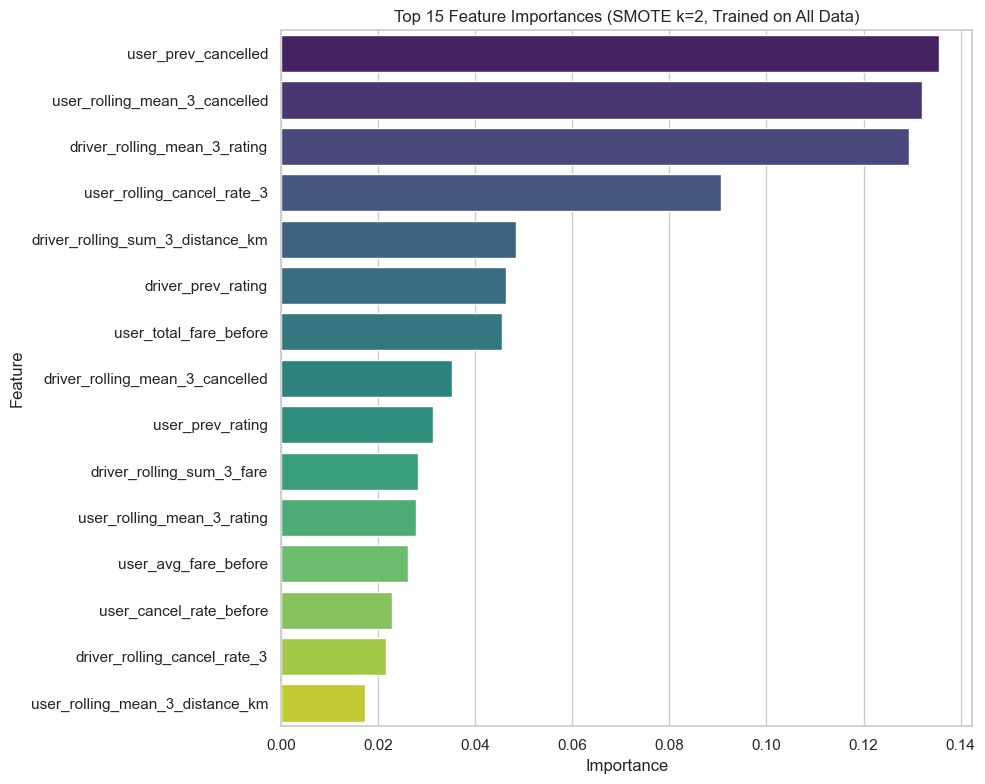


Predictive Modeling Summary:
- Prepared data, handled infinities, set up preprocessing pipeline.
- Used Stratified 4-Fold Cross-Validation with SMOTE (k=2) to address severe class imbalance.
- Average CV Metrics: Accuracy=0.8500, Precision (Class 1)=0.5000, Recall (Class 1)=0.7500, F1 (Class 1)=0.5833
- Feature importances calculated from a model trained on the full dataset (using SMOTE pipeline).
- Conclusion: The dataset is severely limited for predicting cancellations. Even with SMOTE, the lack of sufficient real positive examples prevents reliable model training. More data is critical.


In [ ]:

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Part 3: Predictive Modeling (Revised with SMOTE k=2 in CV) ---

print("\n\n" + "="*50)
print("Part 3: Predictive Modeling (Using SMOTE k=2 in Stratified K-Fold CV)")
print("="*50 + "\n")


if 'df' not in locals() or not isinstance(df, pd.DataFrame):
    print("Error: DataFrame 'df' not found.")
    exit()

# --- 3.1 Feature Selection and Preparation (Same as before) ---
print("--- 3.1 Feature Selection ---")
target = 'cancelled'
potential_features = [col for col in df.columns if col not in [
    'ride_id', 'user_id', 'driver_id', 'cancelled',
    'start_time', 'end_time', 'start_date',
    'rating', 'trip_duration_minutes', 'avg_speed_kmh',
    'user_prev_start_time', 'start_dayname'
]]

df_features = df[potential_features].copy()
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
X = df_features
y = df[target].copy()

print(f"Selected {X.shape[1]} potential features.")
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# --- 3.2 Preprocessing Pipeline Definition (Same as before) ---
print("\n--- 3.2 Preprocessing Pipeline Setup ---")
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)], remainder='passthrough')

# --- 3.3 Model Definition and Pipeline with SMOTE (k=2) ---
print("\n--- 3.3 Model Definition and Pipeline with SMOTE (k=2) ---")
model = RandomForestClassifier(random_state=42, n_estimators=100) # Removed class_weight

n_minority = y.value_counts().min()
# Set k_neighbors to be less than the minimum expected in a training fold (which is 3)
smote_k_neighbors = min(n_minority - 2, 2) # Aim for 2, but ensure it's <= n_minority-2
smote_k_neighbors = max(1, smote_k_neighbors) # Ensure k is at least 1
print(f"Minority samples: {n_minority}. Setting SMOTE k_neighbors={smote_k_neighbors}")
smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)


pipeline_with_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', model)
])
print(f"Using model: {model.__class__.__name__} with SMOTE (k={smote_k_neighbors}) in pipeline")

# --- 3.4 Stratified K-Fold Cross-Validation ---
print("\n--- 3.4 Stratified K-Fold Cross-Validation (with SMOTE k=2) ---")

n_splits = min(n_minority, 4)
if n_splits < 2:
     print(f"Error: Smallest class ({n_minority} samples) too small for CV.")
     exit()

print(f"Using n_splits = {n_splits}")
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy', 'precision_macro': 'precision_macro', 'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro', 'precision_class1': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall_class1': make_scorer(recall_score, pos_label=1, zero_division=0),
    'f1_class1': make_scorer(f1_score, pos_label=1, zero_division=0)
}

print(f"Running cross-validation with SMOTE (k={smote_k_neighbors})...")
try:
    cv_results = cross_validate(pipeline_with_smote, X, y, cv=skf, scoring=scoring, n_jobs=-1, error_score='raise')
    print("Cross-validation complete.")
    cv_successful = True

    avg_accuracy = np.mean(cv_results['test_accuracy'])
    avg_precision_macro = np.mean(cv_results['test_precision_macro'])
    avg_recall_macro = np.mean(cv_results['test_recall_macro'])
    avg_f1_macro = np.mean(cv_results['test_f1_macro'])
    avg_precision_class1 = np.mean(cv_results['test_precision_class1'])
    avg_recall_class1 = np.mean(cv_results['test_recall_class1'])
    avg_f1_class1 = np.mean(cv_results['test_f1_class1'])

except ValueError as e:
    print(f"\nError during cross-validation (with SMOTE k={smote_k_neighbors}): {e}")
    print("This might happen if SMOTE's k_neighbors is >= number of minority samples in a specific fold.")
    print("Even with k=2, if a fold has < 2 minority samples, it can fail. Data may be insufficient.")
    cv_successful = False
except Exception as e:
    print(f"\nAn unexpected error occurred during cross-validation (with SMOTE): {e}")
    cv_successful = False


# --- 3.5 Evaluation Results from Cross-Validation ---
if cv_successful:
    print("\n--- 3.5 Cross-Validation Evaluation Results (with SMOTE k=2) ---")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision (Macro): {avg_precision_macro:.4f}")
    print(f"Average Recall (Macro): {avg_recall_macro:.4f}")
    print(f"Average F1-Score (Macro): {avg_f1_macro:.4f}")
    print("-" * 20)
    print("Metrics specific to Class 1 (Cancelled):")
    print(f"Average Precision (Class 1): {avg_precision_class1:.4f}")
    print(f"Average Recall (Class 1): {avg_recall_class1:.4f}")
    print(f"Average F1-Score (Class 1): {avg_f1_class1:.4f}")

    print("\nIndividual Fold Scores (for reference):")
    cv_results_df = pd.DataFrame(cv_results)
    print(cv_results_df)

    if cv_results_df['test_recall_class1'].sum() > 0:
        print("\nNote: SMOTE (k=2) resulted in some successful Class 1 predictions in at least one fold.")
    else:
        print("\nNote: SMOTE (k=2) did not result in any successful Class 1 predictions across folds.")

    print("\n--- Training Final Model on All Data (with SMOTE k=2 pipeline, for Feature Importance) ---")
    try:
        pipeline_with_smote.fit(X, y)
        print("Final model training complete.")
        if hasattr(model, 'feature_importances_'):
            print("\n--- Feature Importance (from model trained on all data with SMOTE k=2) ---")
            try:
                num_features_out = numerical_features
                cat_features_out = pipeline_with_smote.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
                all_feature_names = num_features_out + list(cat_features_out)
                importances = pipeline_with_smote.named_steps['classifier'].feature_importances_
                if len(all_feature_names) == len(importances):
                    feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
                    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)
                    plt.figure(figsize=(10, 8)); sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis'); plt.title(f'Top 15 Feature Importances (SMOTE k={smote_k_neighbors}, Trained on All Data)'); plt.tight_layout(); plt.show()
                else: print(f"Mismatch in feature names ({len(all_feature_names)}) and importances ({len(importances)}). Skipping plot.")
            except Exception as e: print(f"Could not plot feature importance: {e}")
    except Exception as e: print(f"Error training final model on all data: {e}")

else:
    print("\nSkipping evaluation results as cross-validation failed.")


print("\nPredictive Modeling Summary:")
print("- Prepared data, handled infinities, set up preprocessing pipeline.")
print(f"- Used Stratified {n_splits}-Fold Cross-Validation with SMOTE (k={smote_k_neighbors}) to address severe class imbalance.")
if cv_successful:
    print(f"- Average CV Metrics: Accuracy={avg_accuracy:.4f}, Precision (Class 1)={avg_precision_class1:.4f}, Recall (Class 1)={avg_recall_class1:.4f}, F1 (Class 1)={avg_f1_class1:.4f}")
    if cv_results_df['test_recall_class1'].sum() == 0:
        print("- WARNING: Despite SMOTE (k=2), the model still failed to correctly predict any cancellations during cross-validation.")
    print("- Feature importances calculated from a model trained on the full dataset (using SMOTE pipeline).")
    print("- Conclusion: The dataset is severely limited for predicting cancellations. Even with SMOTE, the lack of sufficient real positive examples prevents reliable model training. More data is critical.")
else:
    print("- Cross-validation with SMOTE failed, likely due to insufficient minority samples within folds even for k=2.")
    print("- Conclusion: The dataset is too small for reliable modeling.")

# Part 4. Operational Insights

In [ ]:
# --- Part 4: Operational Insights ---

print("\n\n" + "="*50)
print("Part 4: Operational Insights")
print("="*50 + "\n")

# --- Error Handling: Check if necessary DataFrames exist ---
if 'df' not in locals() or not isinstance(df, pd.DataFrame):
    print("Error: DataFrame 'df' not found. Cannot generate operational insights.")
    exit()

if 'user_summary' not in locals() or not isinstance(user_summary, pd.DataFrame):
    print("Warning: DataFrame 'user_summary' not found. User-level insights might be limited.")
    user_summary = pd.DataFrame() # Placeholder

if 'feature_importance_df' not in locals() or not isinstance(feature_importance_df, pd.DataFrame):
    print("Warning: DataFrame 'feature_importance_df' not found. Model insights will be missing.")
    feature_importance_df = pd.DataFrame(columns=['Feature', 'Importance']) # Placeholder



Part 4: Operational Insights



## 4.1 Identify Underperforming or Overworked Drivers

In [ ]:
# --- 4.1 Identify Underperforming or Overworked Drivers ---


print("\n--- 4.1 Driver Performance Analysis (Illustrative due to Sample Size) ---")


driver_req_cols = ['driver_id', 'ride_id', 'rating', 'cancelled', 'trip_duration_minutes', 'fare', 'distance_km']
if not all(col in df.columns for col in driver_req_cols):
    print("Warning: Missing required columns for driver analysis. Skipping driver summary.")
    driver_summary = pd.DataFrame() 
else:

    driver_agg_dict = {
        'total_rides': ('ride_id', 'count'),
        'avg_rating_received': ('rating', 'mean'), # Avg rating given by users to this driver
        'total_rides_cancelled': ('cancelled', lambda x: x.eq(1).sum()), # Rides assigned to driver that were cancelled
        'total_duration_minutes': ('trip_duration_minutes', 'sum'), # Total time spent on rides (in sample)
        'total_fare_earned': ('fare', 'sum'),
        'total_distance_km': ('distance_km', 'sum')
    }


    driver_summary = df.groupby('driver_id').agg(**driver_agg_dict).reset_index()

    # Calculate derived metrics
    driver_summary['cancellation_rate'] = (driver_summary['total_rides_cancelled'] / driver_summary['total_rides']).fillna(0)
    driver_summary['avg_fare_per_ride'] = (driver_summary['total_fare_earned'] / driver_summary['total_rides']).fillna(0)
    # completed_duration = completed_rides_df.groupby('driver_id')['trip_duration_minutes'].sum()
    # completed_count = completed_rides_df.groupby('driver_id')['ride_id'].count()
    # driver_summary['avg_duration_per_completed_ride'] = (completed_duration / completed_count).fillna(0)
    driver_summary['avg_duration_per_ride'] = (driver_summary['total_duration_minutes'] / driver_summary['total_rides']).fillna(0)


    print("Driver Summary Statistics:")
    print(driver_summary)

    # --- Identify Potential Outliers (Illustrative) ---
    if driver_summary.shape[0] > 1: # Need at least 2 drivers to compare

        low_rating_threshold = driver_summary['avg_rating_received'].quantile(0.25) # Bottom 25%

        if driver_summary['cancellation_rate'].nunique() > 1:
             high_cancel_threshold = driver_summary['cancellation_rate'].quantile(0.75) # Top 25%
             cancel_condition = (driver_summary['cancellation_rate'] >= high_cancel_threshold)
             cancel_threshold_text = f"Cancel Rate >= {high_cancel_threshold:.2f}"
        else:

             cancel_condition = (driver_summary['cancellation_rate'] > 0)
             cancel_threshold_text = "Cancel Rate > 0"


        underperforming_drivers = driver_summary[
            (driver_summary['avg_rating_received'] <= low_rating_threshold) | cancel_condition
        ]
        print(f"\nPotentially Underperforming Drivers (Rating <= {low_rating_threshold:.2f} or {cancel_threshold_text}):")
        if not underperforming_drivers.empty:
             print(underperforming_drivers[['driver_id', 'avg_rating_received', 'cancellation_rate', 'total_rides']])
        else:
             print("None identified based on sample data and simple thresholds.")

        # Overworked: High total rides, High total duration (relative to others in this sample)

        if driver_summary['total_rides'].nunique() > 1:
            high_rides_threshold = driver_summary['total_rides'].quantile(0.75)
            rides_condition = (driver_summary['total_rides'] >= high_rides_threshold)
            rides_threshold_text = f"Rides >= {high_rides_threshold:.0f}"
        else:
            rides_condition = pd.Series([False] * len(driver_summary)) # No variation
            rides_threshold_text = "N/A (No variation)"

        if driver_summary['total_duration_minutes'].nunique() > 1:
            high_duration_threshold = driver_summary['total_duration_minutes'].quantile(0.75)
            duration_condition = (driver_summary['total_duration_minutes'] >= high_duration_threshold)
            duration_threshold_text = f"Duration >= {high_duration_threshold:.0f} mins"
        else:
            duration_condition = pd.Series([False] * len(driver_summary)) # No variation
            duration_threshold_text = "N/A (No variation)"


        # Define overworked using AND or OR based on business logic
        # Using OR here for illustration
        overworked_drivers = driver_summary[rides_condition | duration_condition]

        print(f"\nPotentially Overworked Drivers ({rides_threshold_text} OR {duration_threshold_text}):")
        if not overworked_drivers.empty:
             print(overworked_drivers[['driver_id', 'total_rides', 'total_duration_minutes']])
        else:
             print("None identified based on sample data (or workload is uniform).")

        print("\n*Note: Driver performance analysis is highly illustrative due to only 4 drivers and 20 rides.*")
    else:
        print("\nSkipping driver outlier identification (only one driver in data).")





Part 4: Operational Insights


--- 4.1 Driver Performance Analysis (Illustrative due to Sample Size) ---
Driver Summary Statistics:
  driver_id  total_rides  avg_rating_received  total_rides_cancelled  \
0        D1            5                  3.0                      1   
1        D2            5                  3.0                      1   
2        D3            5                  3.0                      1   
3        D4            5                  3.0                      1   

   total_duration_minutes  total_fare_earned  total_distance_km  \
0                   150.0               45.0               13.0   
1                   150.0               47.5               14.0   
2                   150.0               50.0               15.0   
3                   150.0               52.5               16.0   

   cancellation_rate  avg_fare_per_ride  avg_duration_per_ride  
0                0.2                9.0                   30.0  
1                0.2                9.5

## 4.2 Spot Peak Demand Times and Locations


--- 4.2 Peak Demand Analysis ---


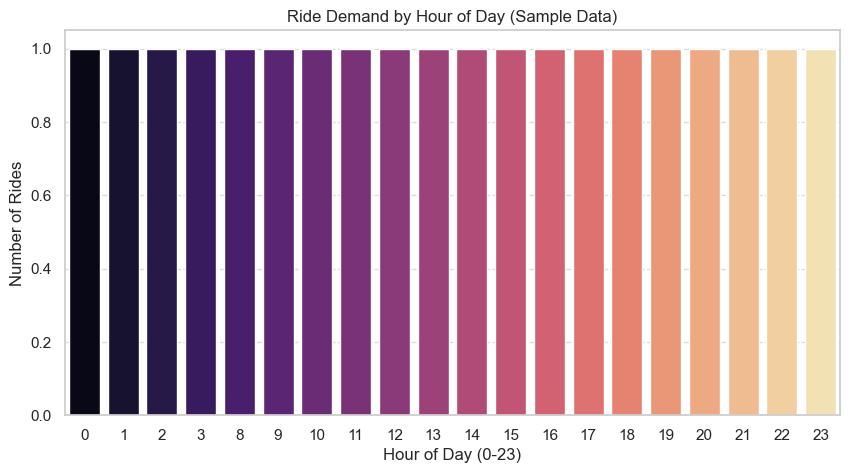

Peak Demand Hours (sample): Hour 0 (1 rides)
Lowest Demand Hours (sample): Hour 0 (1 rides)


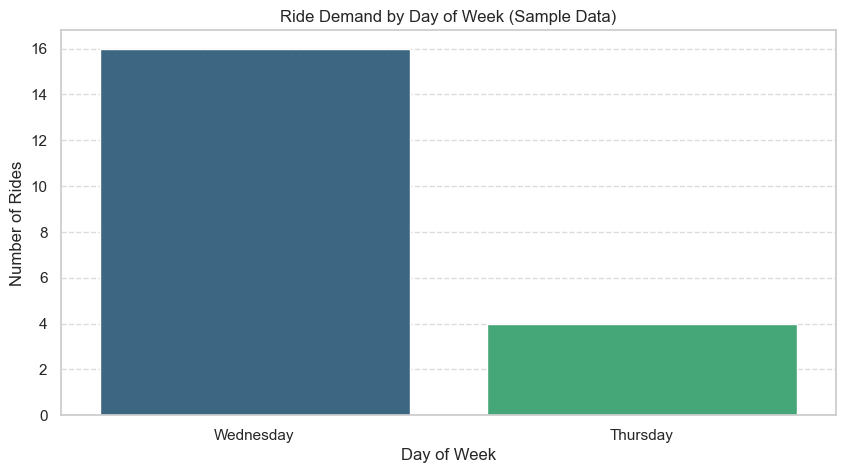

Peak Demand Days (sample): Wednesday (16 rides)
Days observed in sample: ['Wednesday', 'Thursday']


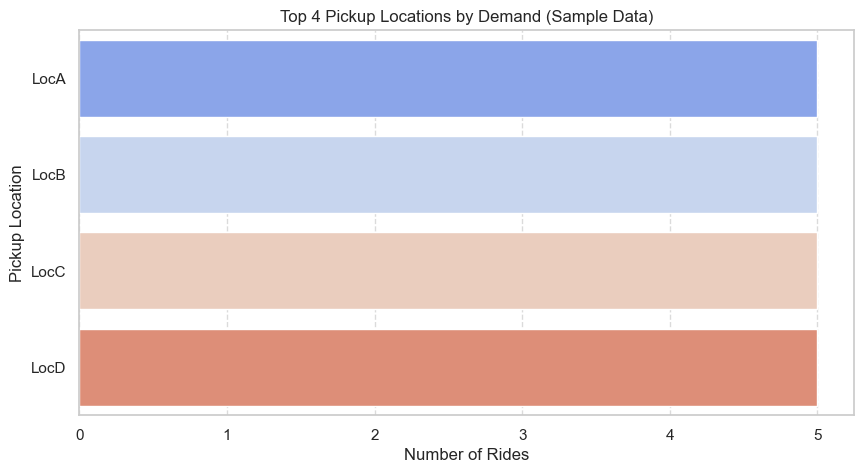

Top Pickup Location (sample): LocA (5 rides)


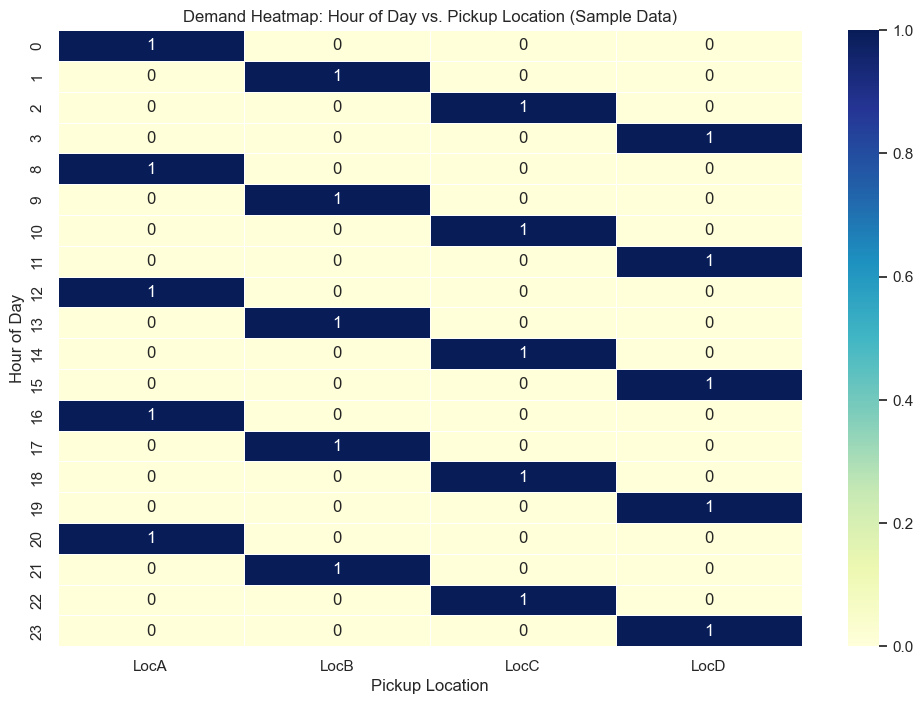

In [ ]:

# --- 4.2 Spot Peak Demand Times and Locations ---

print("\n--- 4.2 Peak Demand Analysis ---")


demand_req_cols = ['start_hour', 'start_dayname', 'pickup_location', 'ride_id']
if not all(col in df.columns for col in demand_req_cols):
    print("Warning: Missing required columns for demand analysis. Skipping.")
else:

    plt.figure(figsize=(10, 5))
    hourly_demand = df.groupby('start_hour')['ride_id'].count()
    if not hourly_demand.empty:
        sns.barplot(x=hourly_demand.index, y=hourly_demand.values, palette='magma')
        plt.title('Ride Demand by Hour of Day (Sample Data)')
        plt.xlabel('Hour of Day (0-23)')
        plt.ylabel('Number of Rides')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        print(f"Peak Demand Hours (sample): Hour {hourly_demand.idxmax()} ({hourly_demand.max()} rides)")
        print(f"Lowest Demand Hours (sample): Hour {hourly_demand.idxmin()} ({hourly_demand.min()} rides)")

    else:
        print("No hourly demand data.")
        hourly_demand = pd.Series() 


    # Peak Days
    plt.figure(figsize=(10, 5))
    daily_demand = df.groupby('start_dayname')['ride_id'].count()

    days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    daily_demand = daily_demand.reindex([d for d in days_order if d in daily_demand.index])
    if not daily_demand.empty:
        sns.barplot(x=daily_demand.index, y=daily_demand.values, palette='viridis')
        plt.title('Ride Demand by Day of Week (Sample Data)')
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Rides')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        print(f"Peak Demand Days (sample): {daily_demand.idxmax()} ({daily_demand.max()} rides)") # Will be Wed/Thu in sample
        print(f"Days observed in sample: {list(daily_demand.index)}")
    else:
        print("No daily demand data.")
        daily_demand = pd.Series() # Define empty


    # Peak Pickup Locations
    plt.figure(figsize=(10, 5))
    location_demand = df['pickup_location'].value_counts()
    if not location_demand.empty:

        n_loc_plot = min(10, location_demand.shape[0])
        top_locations = location_demand.head(n_loc_plot)
        sns.barplot(x=top_locations.values, y=top_locations.index, palette='coolwarm', orient='h')
        plt.title(f'Top {n_loc_plot} Pickup Locations by Demand (Sample Data)')
        plt.xlabel('Number of Rides')
        plt.ylabel('Pickup Location')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()
        print(f"Top Pickup Location (sample): {top_locations.index[0]} ({top_locations.iloc[0]} rides)")

    else:
        print("No location demand data.")
        location_demand = pd.Series() # Define empty


    # Heatmap: Hour vs Location (might be sparse with this data)
    try:

        demand_heatmap = pd.crosstab(df['start_hour'], df['pickup_location'])

        if not demand_heatmap.empty and demand_heatmap.shape[0] > 1 and demand_heatmap.shape[1] > 1:
            plt.figure(figsize=(12, 8))
            sns.heatmap(demand_heatmap, cmap="YlGnBu", linewidths=.5, annot=True, fmt="d")
            plt.title('Demand Heatmap: Hour of Day vs. Pickup Location (Sample Data)')
            plt.xlabel('Pickup Location')
            plt.ylabel('Hour of Day')
            plt.show()
        elif not demand_heatmap.empty:
             print("Skipping demand heatmap: Insufficient variation in hours or locations.")
        else:
            print("Skipping demand heatmap: No data after grouping.")
    except Exception as e:
        print(f"Could not generate demand heatmap: {e}")



## 4.3 Recommend Data-Driven Actions

In [ ]:

# --- 4.3 Recommend Data-Driven Actions ---

print("\n--- 4.3 Recommendations ---")
print("(Note: Recommendations are based EXTREMELY limited sample data and require validation.)")

# --- Data Collection First! ---
print("\n1. CRITICAL: Enhance Data Collection:")
print("   - Volume: The current dataset (20 rides) is insufficient for ANY reliable conclusions. Collect data over months/years.")
print("   - Richness: Add crucial context:")
print("     - Cancellation Reason: User choice, driver choice, no driver available, etc. (MOST IMPORTANT)")
print("     - Driver Status: Time spent online, idle, en route to pickup, on trip.")
print("     - User/Driver Context: App version, device OS, tenure on platform.")
print("     - External Factors: Real-time traffic estimates, weather conditions at start time/location.")
print("     - Promotions: Was a discount applied to the ride request?")
print("     - User Feedback: Text comments associated with low ratings.")

# --- Driver Management ---
print("\n2. Driver Management (Actions require more data):")
if 'driver_summary' in locals() and not driver_summary.empty and driver_summary.shape[0] > 1:
    print("- Performance Monitoring: Once sufficient data exists, establish clear KPIs (completion rate, acceptance rate, avg rating, earnings per hour).")
    print("- Targeted Support: Identify drivers consistently falling below performance benchmarks (low ratings, high cancellations attributable to them). Offer training, feedback, or investigate potential issues.")
    print("- Workload Balancing: Monitor metrics like 'online hours vs. booked hours' to identify potentially overworked or underutilized drivers. Consider incentives or dynamic dispatch algorithms to balance workload.")
else:
    print("- Driver performance analysis skipped or limited due to data constraints.")
print("- Fair Cancellation Tracking: Differentiate between user-initiated and driver-initiated cancellations before penalizing drivers.")

# --- User Retention & Experience ---
print("\n3. User Retention & Experience (Actions require more data):")

if 'user_summary' in locals() and not user_summary.empty and 'segmentation_possible' in locals() and segmentation_possible and 'user_segment' in user_summary.columns and user_summary['user_segment'].nunique() > 1:
    print("- Segment-Specific Strategies:")
    print("  - Analyze the needs and behaviors of segments like 'High Freq - High Spend'. Offer loyalty perks.")
    print("  - Understand why 'Low Freq' users aren't using the service more. Target with tailored promotions.")
    print("  - Investigate segments with high cancellation/low rating rates. Is there a pattern (specific locations, times)?")
else:
    print("- User segmentation insights limited by data.")
print("- Address Pain Points: Analyze low rating reasons (requires collecting comments) to fix root causes (driver behavior, navigation issues, vehicle cleanliness).")

if not feature_importance_df.empty:

     top_features_list = feature_importance_df['Feature'].head(5).tolist()
     if any('cancel_rate_before' in f for f in top_features_list):
         print("- Proactive Engagement (Use with Caution): If past cancellation rate proves strongly predictive (with more data!), consider subtle interventions for high-risk users (double-check cancellation confirmation), but avoid overly penalizing.")
     if any('days_since_last_ride' in f for f in top_features_list):
         print("- Re-engagement Campaigns: If recency is predictive of churn/cancellation, target users inactive for a defined period with special offers.")
else:
    print("- Cancellation model insights unavailable or unreliable.")


# --- Operational Efficiency ---
print("\n4. Operational Efficiency (Actions require more data):")

if 'hourly_demand' in locals() and not hourly_demand.empty and 'location_demand' in locals() and not location_demand.empty:
    peak_hour = hourly_demand.idxmax()
    top_loc = location_demand.index[0]
    print("- Demand Forecasting: Develop a time series model (ARIMA, Prophet) to predict demand by zone/hour with more data.")
    print(f"- Dynamic Driver Allocation: Use demand forecasts to suggest optimal locations (like '{top_loc}') for drivers to wait during anticipated peak times (like hour {peak_hour}).")
    print("- Surge Pricing Refinement: Use granular demand data (time, location) to optimize dynamic pricing, balancing supply, demand, and user sensitivity.")

else:
    print("- Demand analysis insights limited by data.")


# --- Model Enhancement & Testing ---
print("\n5. Model & Strategy Enhancement:")
print("- Iterate on Models: With more data, retrain the cancellation model. Experiment with:")
print("  - Different algorithms (Logistic Regression, Gradient Boosting - XGBoost/LightGBM).")
print("  - Hyperparameter tuning (GridSearchCV, RandomizedSearchCV).")
print("  - More sophisticated Feature Engineering (location interactions, time-based interactions).")
print("- A/B Testing: Rigorously test ANY implemented change (new incentive, UI change, model deployment) using A/B testing to measure its actual impact on KPIs (cancellations, conversion, revenue, etc.).")



--- 4.3 Recommendations ---
(Note: Recommendations are based EXTREMELY limited sample data and require validation.)

1. CRITICAL: Enhance Data Collection:
   - Volume: The current dataset (20 rides) is insufficient for ANY reliable conclusions. Collect data over months/years.
   - Richness: Add crucial context:
     - Cancellation Reason: User choice, driver choice, no driver available, etc. (MOST IMPORTANT)
     - Driver Status: Time spent online, idle, en route to pickup, on trip.
     - User/Driver Context: App version, device OS, tenure on platform.
     - External Factors: Real-time traffic estimates, weather conditions at start time/location.
     - Promotions: Was a discount applied to the ride request?
     - User Feedback: Text comments associated with low ratings.

2. Driver Management (Actions require more data):
- Performance Monitoring: Once sufficient data exists, establish clear KPIs (e.g., completion rate, acceptance rate, avg rating, earnings per hour).
- Targeted Sup

# Part 5. Time Series

In [ ]:
# --- 0. Setup and Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             make_scorer, classification_report,
                             confusion_matrix, accuracy_score)
from imblearn.over_sampling import SMOTE

from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

import warnings

warnings.filterwarnings('ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=UserWarning) 
warnings.filterwarnings('ignore', category=RuntimeWarning) 


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("Libraries imported and settings configured.")



df = pd.read_csv('data/HR_Assessment_Data_Data Scientist_Raw Data.csv')

try:
    df['start_time'] = pd.to_datetime(df['start_time'])
    time_conversion_success_part5 = True
except Exception:
    time_conversion_success_part5 = False



print("\n\n" + "="*50)
print("Part 5: Basic Time Series Forecast of Demand")
print("="*50 + "\n")
print("NOTE: This forecast is purely illustrative due to the extremely limited")
print("      amount of data (20 rides over approx. 2 days).")
print("      Real-world forecasting requires significantly more historical data.")

Libraries imported and settings configured.


Part 5: Basic Time Series Forecast of Demand

NOTE: This forecast is purely illustrative due to the extremely limited
      amount of data (20 rides over approx. 2 days).
      Real-world forecasting requires significantly more historical data.


## 5.1 Prepare Data for Time Series

In [ ]:


# --- 5.1 Prepare Data for Time Series ---


if not time_conversion_success_part5:
    print("\nError: 'start_time' column is missing or not in datetime format. Cannot proceed with time series forecast.")
    time_series_skipped = True
else:
    time_series_skipped = False
    print("\nAggregating ride count by hour...")

    df_ts = df.set_index('start_time')

    hourly_demand = df_ts['ride_id'].resample('H').count().fillna(0)


    print("\nHourly Demand Time Series (Sample):")
    print(hourly_demand.head())
    print(f"Time series length: {len(hourly_demand)} hours (including hours with 0 rides)")
    print(f"Time range: {hourly_demand.index.min()} to {hourly_demand.index.max()}")


    min_obs_for_model = 5 # Arbitrary small number for demonstration
    if len(hourly_demand) < min_obs_for_model:
        print(f"\nWarning: Very few data points ({len(hourly_demand)}) for time series analysis. Forecast will be unreliable.")

        time_series_skipped = True


Aggregating ride count by hour...

Hourly Demand Time Series (Sample):
start_time
2025-01-01 08:00:00    1
2025-01-01 09:00:00    1
2025-01-01 10:00:00    1
2025-01-01 11:00:00    1
2025-01-01 12:00:00    1
Freq: h, Name: ride_id, dtype: int64
Time series length: 20 hours (including hours with 0 rides)
Time range: 2025-01-01 08:00:00 to 2025-01-02 03:00:00


## 5.2 Fitted Time Series & Generate Forecast


Fitting Simple Exponential Smoothing model...
SES Model Fitted. Optimal smoothing level (alpha): 0.7993023255813954

Generating forecast for the next 6 hours...

Forecasted Hourly Demand:
2025-01-02 04:00:00    1.0
2025-01-02 05:00:00    1.0
2025-01-02 06:00:00    1.0
2025-01-02 07:00:00    1.0
2025-01-02 08:00:00    1.0
2025-01-02 09:00:00    1.0
Freq: h, dtype: float64


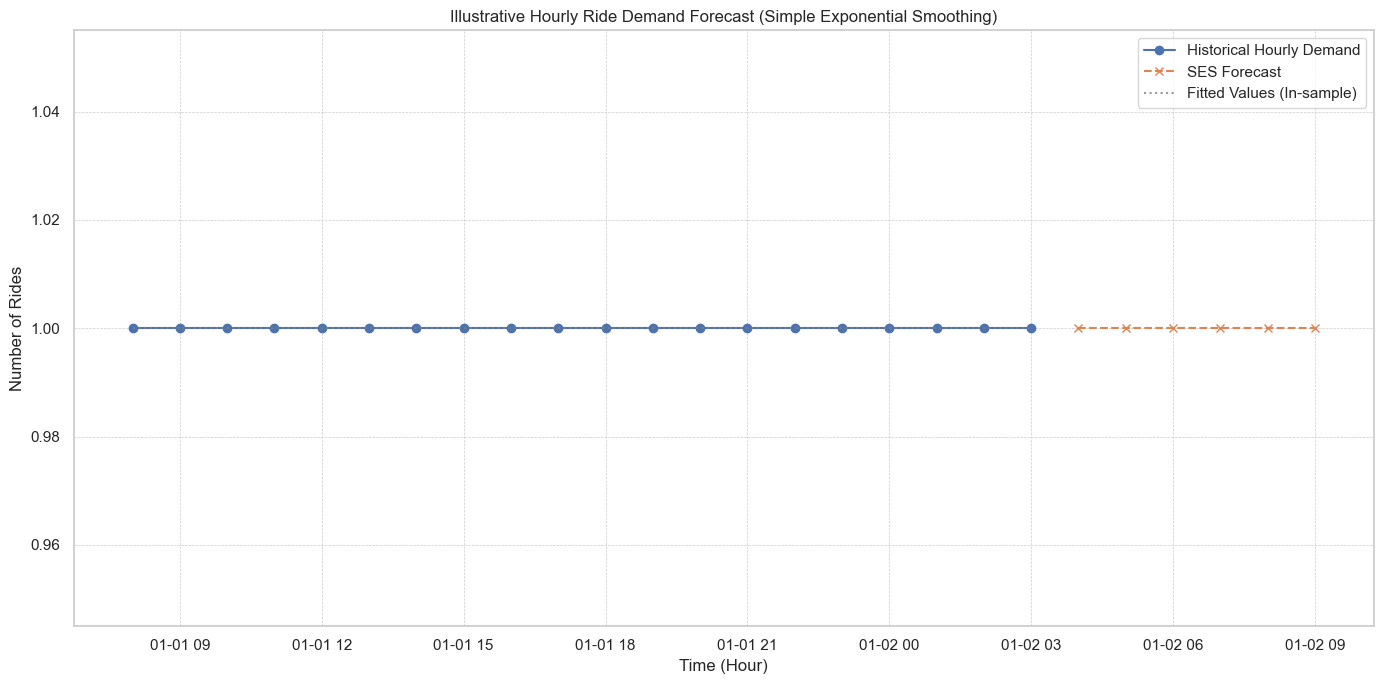


Reminder: This forecast is based on minimal data and likely has very low accuracy.
It primarily demonstrates the process, not a reliable prediction.
SES assumes no trend or seasonality, which is unlikely for real ride demand.


In [ ]:

if not time_series_skipped:
    # --- 5.2 Fit a Simple Time Series Model ---

    try:
        print("\nFitting Simple Exponential Smoothing model...")
        model_ses = SimpleExpSmoothing(hourly_demand, initialization_method="estimated").fit(optimized=True)
        smoothing_level_param = model_ses.params.get('smoothing_level', 'N/A') # Get param safely
        print(f"SES Model Fitted. Optimal smoothing level (alpha): {smoothing_level_param if smoothing_level_param != 'N/A' else 'Not Available'}")
        model_fitted = True
    except Exception as e:
        print(f"\nError fitting time series model: {e}")
        print("This might be due to insufficient data or lack of variation.")
        model_fitted = False
    # --- 5.3 Generate Forecast ---
    if model_fitted:
        print("\nGenerating forecast for the next 6 hours...")

        forecast_periods = 6
        forecast = model_ses.forecast(steps=forecast_periods)

        print("\nForecasted Hourly Demand:")

        print(forecast.round(2)) 

        # --- 5.4 Visualize Forecast ---
        plt.figure(figsize=(14, 7)) # Slightly larger figure
        plt.plot(hourly_demand.index, hourly_demand, label='Historical Hourly Demand', marker='o', linestyle='-')

        # Plot forecast values
        plt.plot(forecast.index, forecast, label='SES Forecast', marker='x', linestyle='--')

        fitted_values = model_ses.fittedvalues
        plt.plot(fitted_values.index, fitted_values, label='Fitted Values (In-sample)', linestyle=':', color='grey', alpha=0.8)

        plt.title('Illustrative Hourly Ride Demand Forecast (Simple Exponential Smoothing)')
        plt.xlabel('Time (Hour)')
        plt.ylabel('Number of Rides')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Add grid lines
        plt.tight_layout()

        plt.show()

        print("\nReminder: This forecast is based on minimal data and likely has very low accuracy.")
        print("It primarily demonstrates the process, not a reliable prediction.")
        print("SES assumes no trend or seasonality, which is unlikely for real ride demand.")

    else:
        print("\nSkipping forecast generation and visualization due to model fitting error.")

else:
    print("\nSkipping Time Series Forecast due to data preparation issues or insufficient data.")